In [2]:
# Importing necessary libraries for the analysis.
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import csv
import math
import json
from scipy.ndimage import uniform_filter1d
from tqdm import tqdm
import pandas as pd, datetime


from utils import *
from autoencoder_networks import *
from diffusion_networks import *
from sampler import *
from calculations import *
from loss import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cmap = plt.cm.get_cmap('viridis', 30)

# Data Loading

## QG

In [3]:
# QG Dataset

batch_size = 64 # 256 Largest possible batch size that fits on the GPU w.f32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mean_data = 0.003394413273781538
std_data = 9.174626350402832
norm_factors = (mean_data, std_data)

iterations = 2101000
spinup = 1001
spacing = 1
p_train = 0.8

n_samples = iterations+1
n_train = int(np.round(p_train * (n_samples - spinup)))  # Number of training samples
n_val = int(np.round((1 - p_train) / 2 * (n_samples - spinup)))  # Number of validation samples
sample_counts = (n_samples, n_train, n_val)

on_remote = False
fname= f'QG_samples_SUBS_{iterations}.npy'
subd = 'C:/Users/svart/Desktop/MEX/data/'
if on_remote:
    subd = '/nobackup/smhid20/users/sm_maran/dpr_data/simulations'
dataset_path = Path(f'{subd}/{fname}')


grid_dimensions = (65, 65)
max_lead_time = 150

QG_kwargs = {
            'dataset_path':     dataset_path,
            'sample_counts':    sample_counts,
            'grid_dimensions':  grid_dimensions,
            'max_lead_time':    max_lead_time,
            'norm_factors':     norm_factors,
            'device':           device,
            'spinup':           spinup,
            'spacing':          spacing,
            'dtype':            'float32'
            }

In [4]:
# Way to load a dataset with a specific lead time
train_dataset = QGDataset(lead_time=100, dataset_mode='train', **QG_kwargs)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Way to load a dataset with a specific lead time
val_dataset = QGDataset(lead_time=150, dataset_mode='val', **QG_kwargs)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Way to load a dataset with lead time following a distribution given by update_k_per_batch
update_k_per_batch = get_uniform_k_dist_fn(kmin=1, kmax=150, d=1)

train_time_dataset = QGDataset(lead_time=max_lead_time, dataset_mode='train', **QG_kwargs)
train_batch_sampler = DynamicKBatchSampler(train_time_dataset, batch_size=batch_size, drop_last=True, k_update_callback=update_k_per_batch, shuffle=True)
train_time_loader = DataLoader(train_time_dataset, batch_sampler=train_batch_sampler)

# Way to load a single trajectory. Only uses 1 batch.
t_kmin = 50
t_kmax = 150
t_d = 50
k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **QG_kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

In [5]:
precomputed_std = torch.tensor(np.loadtxt('stds.txt',delimiter=' ')[:,1], dtype=torch.float32).to(device)
def residual_scaling(x):
    return precomputed_std[x.to(dtype=int)-1]

## WB

In [80]:
# WB Dataset

batch_size = 64 # 256 Largest possible batch size that fits on the GPU w.f32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
offset = 2**7

mean_data = 54112.887 
std_data = 3354.9524
norm_factors = (mean_data, std_data)

spacing = 1
spinup = 0
ti = pd.date_range(datetime.datetime(1979,1,1,0), datetime.datetime(2018,12,31,23), freq='1h')
n_train = sum(ti.year <= 2015)
n_val = sum((ti.year >= 2016) & (ti.year <= 2017))
n_samples = len(ti)
sample_counts = (n_samples, n_train, n_val)

on_remote = False
fname= 'geopotential_500hPa_1979-2018_5.625deg.npy'
subd = 'C:/Users/svart/Desktop/MEX/data/'
if on_remote:
    subd = '/nobackup/smhid20/users/sm_tland/wb1/geopotential_500'
dataset_path = Path(f'{subd}/{fname}')

grid_dimensions = (32, 64)
max_lead_time = 150

WB_kwargs = {
            'dataset_path':     dataset_path,
            'sample_counts':    sample_counts,
            'grid_dimensions':  grid_dimensions,
            'max_lead_time':    max_lead_time,
            'norm_factors':     norm_factors,
            'device':           device,
            'spinup':           spinup,
            'spacing':          spacing,
            'dtype':            'float32',
            'offset':           offset
            }

In [81]:
# Way to load a dataset with a specific lead time
lead_time = 6
train_dataset = QGDataset(lead_time=lead_time,dataset_mode='train', **WB_kwargs)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [40]:
# Way to load a dataset with lead time following a distribution given by update_k_per_batch
kmin = 1
kmax = 36
d = 1

update_k_per_batch = get_uniform_k_dist_fn(kmin, kmax, d)

train_time_dataset = QGDataset(lead_time=kmax, dataset_mode='train', **WB_kwargs)
train_batch_sampler = DynamicKBatchSampler(train_time_dataset, batch_size=batch_size, drop_last=True, k_update_callback=update_k_per_batch, shuffle=True)
train_time_loader = DataLoader(train_time_dataset, batch_sampler=train_batch_sampler)

In [42]:
# Way to load a single trajectory. Only uses 1 batch.
kmin = 50
kmax = 150
d = 50
k_series = kmin + d * np.arange(0, 1 + (kmax-kmin)//d)

val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **WB_kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

## QG NWP comparison

In [7]:
# Numerical model
n_val = 210000

#nwp_data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_LRES_{iterations}_n_{n_val}_k_{k}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_LRES_{iterations}_n_{n_val}_k_{k}.npy')
nwp_data_path = Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_LRES_Test_{iterations}_n_{n_val}_k_{k}.npy')

nwp_dataset = NWPDataset(nwp_data_path, n_val=n_val, spacing=spacing, device=device)
nwp_loader = DataLoader(nwp_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Fixed k sampling
kmin = 1
kmax = 150
d = 1

nwp_data_path = Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_LRES_Test_2101000_n_210000_1_k_150.npy')

nwp_time_series_dataset = NWPTimeSeriesDataset(nwp_data_path, 'val', p_train, kmin, kmax, d, spinup, spacing, 210000, mean_data, std_data, device, dtype='float64', offset=2**7)
nwp_time_series_loader = DataLoader(nwp_time_series_dataset, batch_size=1, shuffle=False)

# Load Models

In [6]:
# Load Autoencoder
autoencoder_date = '2024-02-21'
autoencoder_model = 'ae-2ds-32f-1l-150e-L1-0wd-0.00001l1'

autoencoder_path = Path(f'/nobackup/smhid20/users/sm_maran/results/{autoencoder_date}/{autoencoder_model}/') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/results/{autoencoder_date}/{autoencoder_model}/')
saved_model = torch.load(autoencoder_path / 'best_model.pth')

with open(autoencoder_path / 'config.json', 'r') as json_file:
    parameters = json.load(json_file)

filters = parameters['filters']
latent_dim = parameters['latent_dim']
no_downsamples = parameters['no_downsamples']

autoencoder = Autoencoder(filters= filters, no_latent_channels=latent_dim, no_downsamples=no_downsamples)
autoencoder.load_state_dict(saved_model)
autoencoder.to(device)
autoencoder.eval()

print("Autoencoder loaded successfully!")

Autoencoder loaded successfully!


In [14]:
# Load Diffusion model
diffusion_date = '2024-02-29'
result_model = f'ncsnpp-f32-k{k}'

result_path = Path(f'/nobackup/smhid20/users/sm_maran/results/{diffusion_date}/{result_model}/') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/results/{diffusion_date}/{result_model}/')
saved_model = torch.load(result_path / 'best_model.pth')

with open(result_path / 'config.json', 'r') as json_file:
    parameters = json.load(json_file)

filters = parameters['filters']
model_name = parameters['model']
k = parameters['k']

forecasting = True
model = GCPrecond(filters=filters, img_channels=2 if forecasting else 1, model='ncsnppOriginal', img_resolution = 16, time_emb=0)

model.load_state_dict(saved_model)
model.to(device)
model.eval()
print("Diffusion Model loaded successfully!")

Diffusion Model loaded successfully!


### Scaling function

In [15]:
def calculate_latent_mean_std():
    # Calculate mean and var
    # Initialize variables for mean and standard deviation
    mean_data_latent = 0.0
    std_data_latent = 0.0
    count = 0
    #autoencoder.to('cpu')
    # Iterate over the batches in train_loader
    autoencoder.eval()
    with torch.no_grad():
        for current, next in train_loader:
            # Get the input data from the batch
            latent = autoencoder.encoder(current)
            next_latent = autoencoder.encoder(next)
            
            inputs = next_latent -  latent

            count += inputs.size(0)

            # Calculate the sum of the input data
            mean_data_latent += torch.sum(inputs)
            std_data_latent += torch.sum(inputs ** 2)
            #print(mean_data_latent/count, std_data_latent/count, count)
            break
            
        # Calculate the mean and standard deviation
        count = count * inputs[0].cpu().detach().numpy().size
        # TODO
        mean_data_latent /= count
        std_data_latent = torch.sqrt(std_data_latent / count - mean_data_latent ** 2)

        # Print the mean and standard deviation
        #print("Mean:", mean_data_latent.item())
        #print("Standard Deviation:", std_data_latent.item())

    return mean_data_latent, std_data_latent

calculate_latent_mean_std()
print(mean_data_latent, std_data_latent, std_residual_latent)

-0.6132266521453857 5.066834926605225 5.375336170196533


In [16]:
# Fit the residual scaling
ks = np.arange(1,151,1)
stds = []
for k in ks:
    train_dataset = QGDataset(data_path, 'train', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
    train_loader = DataLoader(train_dataset, batch_size = 2048, shuffle=True)

    _, std_latent_k = calculate_latent_mean_std()
    stds.append(std_latent_k.item())
    print(k, std_latent_k.item())

1 0.30440154671669006
2 0.5873209238052368
3 0.8301824927330017
4 1.0534664392471313
5 1.2819483280181885


KeyboardInterrupt: 

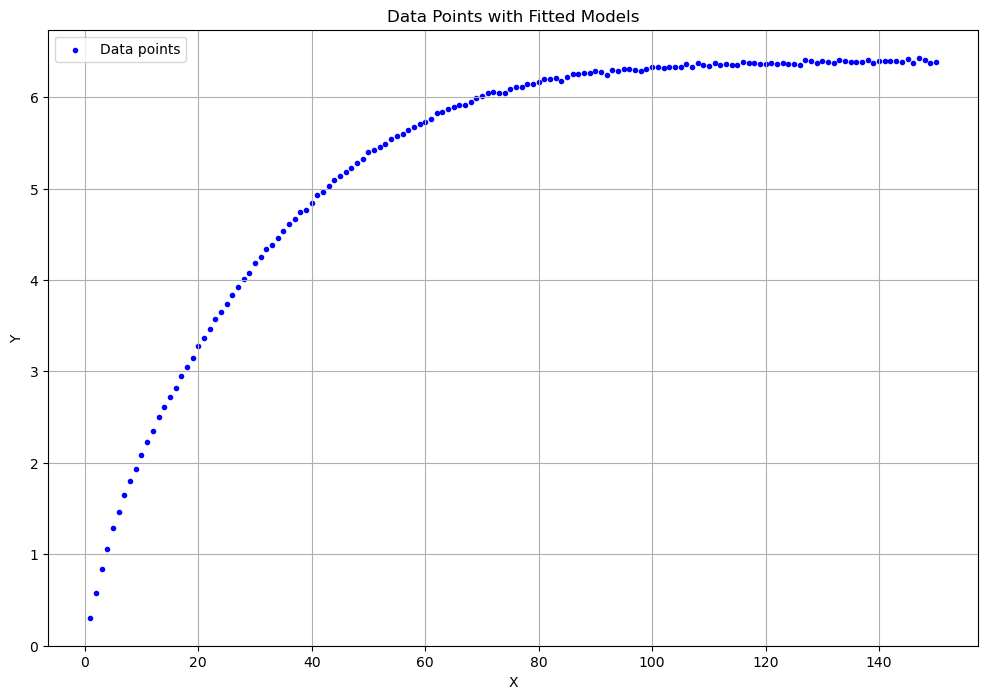

In [ ]:
x = ks[:]
y = stds[:]


# Plotting the original data and the fitted models
plt.figure(figsize=(12, 8))
plt.scatter(x, y, color='blue', label='Data points', marker='.')
#plt.plot(x, y_fitted_log, color='red', label='Log Model')
#plt.plot(x, y_fitted_logistic, color='green', label='Logistic Model')
plt.title('Data Points with Fitted Models')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.show()


# Training

In [7]:
# Setup for training

forecasting = True

num_epochs = 10

model = EDMPrecond(filters=32, img_channels=2 if forecasting else 1, img_resolution = 16, time_emb=1, model_type='standard', sigma_data=1, sigma_min=0.02, sigma_max=88)
print("Num params: ", sum(p.numel() for p in model.parameters()))

model.to(device)
 
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)
#optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.001)
loss_fn = GCLoss(time_noise=0)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
warmup_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.001, end_factor=1.0, total_iters=100)
loss_values = []
val_loss_values = []
best_val_loss = float('inf')

# Setup for logging
log_file_path = 'training_log.csv'
with open(log_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Average Training Loss', 'Validation Loss'])

Num params:  3402721


In [8]:
model.load_state_dict(torch.load('models/240414k1-150-100ep.pth'))

<All keys matched successfully>

In [ ]:
# Training time dependent model
# Training
import time
from tqdm import tqdm

# Training loop

log_interval = 100#len(train_loader) // 4

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()  # Set model to training mode
    total_train_loss = 0

    current_loss = 0
    count = 0


    for previous, current, time_label in tqdm(train_time_loader):
        current = current.to(device)
        previous = previous.to(device)
        time_label = time_label.to(device)
        
        count += 1
        optimizer.zero_grad()
        
        with torch.no_grad():
            current_latent = autoencoder.encoder(current)

            previous_latent = autoencoder.encoder(previous)
            target_latent = (current_latent - previous_latent) / residual_scaling(time_label[0])
            
        time_label = time_label/max_lead_time
        loss = loss_fn(model, target_latent, previous_latent, time_label.to(torch.float32))

        total_train_loss += loss.item()
        current_loss += loss.item()

        loss.backward()
        optimizer.step()

        
        if count % log_interval == 0:
            # Calculate and log the current average loss
            current_loss = current_loss / count

            print(f'Average Loss: {current_loss:.4f}')

            current_loss = 0
            count = 0
        
        warmup_scheduler.step()
            
    avg_train_loss = total_train_loss / len(train_time_loader)
    
    train_time = time.time() - start_time
    start_time = time.time()

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for previous, current, time_label in tqdm(val_loader):
            current = current.to(device)
            previous = previous.to(device)
            
            current_latent = autoencoder.encoder(current)
            previous_latent = None

            if forecasting:
                previous_latent = autoencoder.encoder(previous)
                target_latent = (current_latent - previous_latent) / residual_scaling(time_label[0])
            
            time_label = time_label/kmax
            loss = loss_fn(model, target_latent, previous_latent, time_label)
            
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    val_time = time.time() - start_time
    start_time = time.time()
    
    scheduler.step()

    sample_time = time.time() - start_time
    
    # Log to CSV    
    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists
    
    # Log to CSV
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss])
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    print(f'Training time: {train_time:.5f}s, Validation time: {val_time:.5f}s, Sample time: {sample_time:.5f}s')
    torch.save(model.state_dict(), 'final_model.pth')


# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.plot(loss_plot[1:], label='Training Loss', color='blue')

plt.plot(val_loss_values[1:], label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

# Generation

In [9]:
def generate_ensemble_from_single_random(model, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler):
    model.eval()

    for previous, current, time_label in selected_loader:
        time_labels = torch.ones(n_ens, device=device, dtype=int) * time_label[0]
        previous_unbatched = previous[0].unsqueeze(0).to(device)
        current_unbatched = current[0].unsqueeze(0).to(device)
        break
    
    with torch.no_grad():
        previous_latent = autoencoder.encoder(previous_unbatched)

        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        
        latents = torch.randn_like(class_labels, device=device)
        #latents = torch.randn_like(previous_latent, device=device).repeat(n_ens, 1, 1, 1)

        predicted_residuals = sampler_fn(model, latents, class_labels, time_labels / max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        predicted_latent = previous_latent + predicted_residuals * residual_scaling(time_label[0])
        
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data
        current_unnormalized = current_unbatched * std_data + mean_data
        previous_unnormalized = previous_unbatched * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, 1, previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized, current_unnormalized, previous_unnormalized

#predicted_unnormalized, current_unnormalized, previous_unnormalized = generate_ensemble_from_single_random(model, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler)

In [72]:
def generate_ar_ensemble_from_single_random(model, rollout, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler):
    model.eval()

    for previous, current, time_label in selected_loader:
        time_labels = torch.ones(n_ens, device=device, dtype=int) * time_label[0]
        previous_unbatched = previous[0].unsqueeze(0).to(device)
        current_unbatched = current[0].unsqueeze(0).to(device)
        break
    
    with torch.no_grad():
        previous_latent = autoencoder.encoder(previous_unbatched)

        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        
        latents = torch.randn_like(class_labels, device=device)

        for i in range(rollout):
            predicted_residuals = sampler_fn(model, latents, class_labels, time_labels / max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)

            predicted_latent = class_labels + predicted_residuals * residual_scaling(time_label[0])
            
            class_labels = predicted_latent
        
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data
        current_unnormalized = current_unbatched * std_data + mean_data
        previous_unnormalized = previous_unbatched * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, 1, previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized, current_unnormalized, previous_unnormalized

#predicted_unnormalized, current_unnormalized, previous_unnormalized = generate_ar_ensemble_from_single_random(model, rollout=2, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler)

In [10]:
def generate_ensemble_from_batch(model, previous, lead_time, n_ens=10, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    with torch.no_grad():
        previous = previous.to(device)
        previous_latent = autoencoder.encoder(previous)
        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        time_labels = torch.ones(class_labels.shape[0], device=device, dtype=int) * lead_time / max_lead_time

        latents = torch.randn_like(class_labels, device=device)

        predicted_residuals = sampler_fn(model, latents, class_labels, time_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)

        predicted_latent = class_labels + predicted_residuals * residual_scaling(torch.tensor(lead_time))
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, previous.size(0), previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized

#predicted_unnormalized = generate_ensemble_from_batch(model, next(iter(val_loader))[0], lead_time, n_ens=1)

In [11]:
def generate_ar_ensemble_from_batch(model, previous, lead_time, rollout, n_ens=10, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    with torch.no_grad():
        previous = previous.to(device)
        previous_latent = autoencoder.encoder(previous)
        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        time_labels = torch.ones(class_labels.shape[0], device=device, dtype=int) * lead_time / max_lead_time
        latents = torch.randn_like(class_labels, device=device)

        for i in range(rollout):
            predicted_residuals = sampler_fn(model, latents, class_labels, time_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)

            predicted_latent = class_labels + predicted_residuals * residual_scaling(torch.tensor(lead_time))
            
            class_labels = predicted_latent
        
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, previous.size(0), previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized

#predicted_unnormalized = generate_ar_ensemble_from_batch(model, next(iter(val_loader))[0], lead_time=10, rollout=3, n_ens=1)

# **Evaluation**

## ***Calculations***

Batched input (n_ens, batch_size, img_channels, img_resolution, img_resolution)

In [58]:
# This does work for unbatched data currently
forecast, truth, _ = generate_ensemble_from_single_random(model, n_ens=10, selected_loader = train_loader, sampler_fn=heun_sampler)
skill, spread, ratio = calculate_skill_and_spread_score(forecast, truth)
crps = calculate_CRPS(forecast, truth)
brier = calculate_brier_score(forecast, truth, 20)

print(f"Skill: {skill[0]:.2f}, Spread: {spread[0]:.2f}, Ratio: {ratio[0]:.3f}, CRPS: {crps[0]:.3f}, Brier: {brier[0]:.4f}")

Skill: 4.16, Spread: 4.06, Ratio: 1.024, CRPS: 1.453, Brier: 0.0069


### QG NWP

Code to calculate nwp skill and climatology.
Not the best code, nwp_dataset should really be updated if we want to use it properly.

In [58]:
# For QG NWP

def calculate_nwp_skill(n_batches=2, selected_loader=val_loader):
    count = 0

    results = {'skill': []}

    for (previous, current, _), nwp in zip(selected_loader, nwp_loader):
        print(count)
        if count >= n_batches:
            break
        
        current = current.to(device)
        nwp = nwp.to(device)
        current_unnormalized = current * std_data + mean_data

        skill = calculate_RMSE(nwp, current_unnormalized).flatten()
        results['skill'].append(skill)

        count += 1

    results = {key: np.concatenate(value) for key, value in results.items()}

    # Just return skill for now
    return results['skill']

def calculate_climatology(selected_loader, n_batches=2):
    mean = 0
    count = 0
    with torch.no_grad():
        for _, current,_ in tqdm(selected_loader):
            current = current.to(device)
            if count >= n_batches:
                break
            mean += torch.sum(current, dim=0)
            count += 1
    
    count = count * current.size(0)
    mean = mean / count

    return mean.unsqueeze(0)

In [ ]:
n_val = 210000
nwp_lead_time = 50

# Way to load a dataset with a specific lead time
val_compare_dataset = QGDataset(lead_time=nwp_lead_time, dataset_mode='val', **QG_kwargs)
val_compare_loader = DataLoader(val_compare_dataset, batch_size=batch_size, shuffle=False)

nwp_data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_LRES_{iterations}_n_{n_val}_k_{nwp_lead_time}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_LRES_{iterations}_n_{n_val}_k_{nwp_lead_time}.npy')

nwp_dataset = NWPDataset(nwp_data_path, n_val=n_val, spacing=spacing, device=device)
nwp_loader = DataLoader(nwp_dataset, batch_size=batch_size, shuffle=False)

climatology = calculate_climatology(train_loader, n_batches=10)
nwp_skill = calculate_nwp_skill(n_batches=10, selected_loader=val_compare_loader)

  0%|          | 0/26248 [00:00<?, ?it/s]

  0%|          | 10/26248 [00:00<37:19, 11.71it/s] 


0
1
2
3
4
5
6
7
8
9
10


## ***Plotting***

### Denoising of states over time

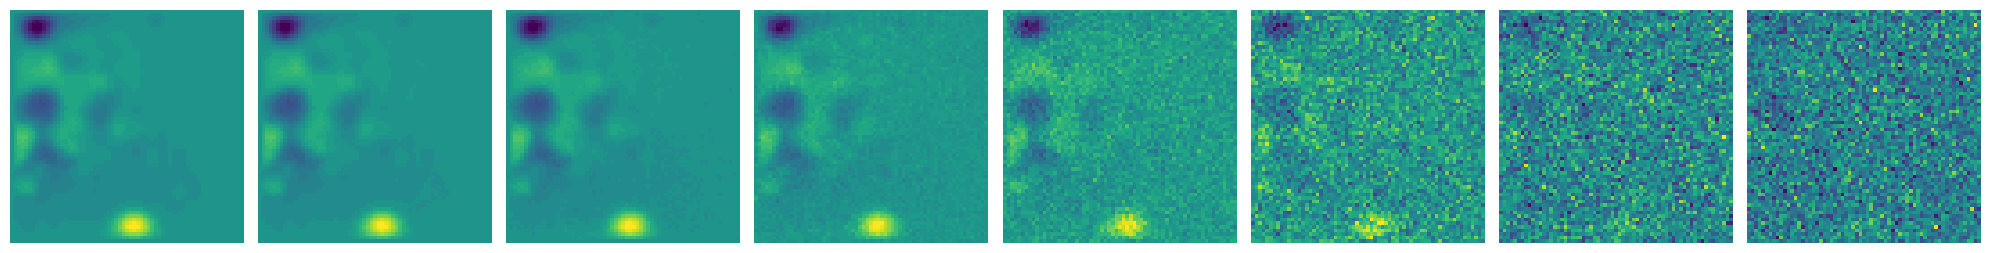

In [57]:
"""

Plot the denoising of random states

"""

image =  next(iter(train_loader))[0][0,0] * std_data + mean_data

noisy_images = []
max_num = 8
for i in range(max_num):

    rnd_uniform = 1 - i/(max_num-1)
    rho_inv = 1 / 7
    sigma_max_rho = 88 ** rho_inv
    sigma_min_rho = 0.02 ** rho_inv
    
    sigma = (sigma_max_rho + rnd_uniform * (sigma_min_rho - sigma_max_rho)) ** 7

    weight = (sigma ** 2 + 1 ** 2) / (sigma * 1) ** 2

    noise = torch.randn_like(image)
    noisy_image = image + sigma * noise
     
    noisy_images.append(noisy_image.cpu().detach().numpy())

fig, axes = plt.subplots(1, max_num, figsize=(20, 4))
for i in range(max_num):
    axes[i].imshow(noisy_images[i], cmap=cmap)
    axes[i].axis('off')

plt.tight_layout()

plt.savefig('noisy_images.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

### Standard plot of ensembles

<Figure size 640x480 with 0 Axes>

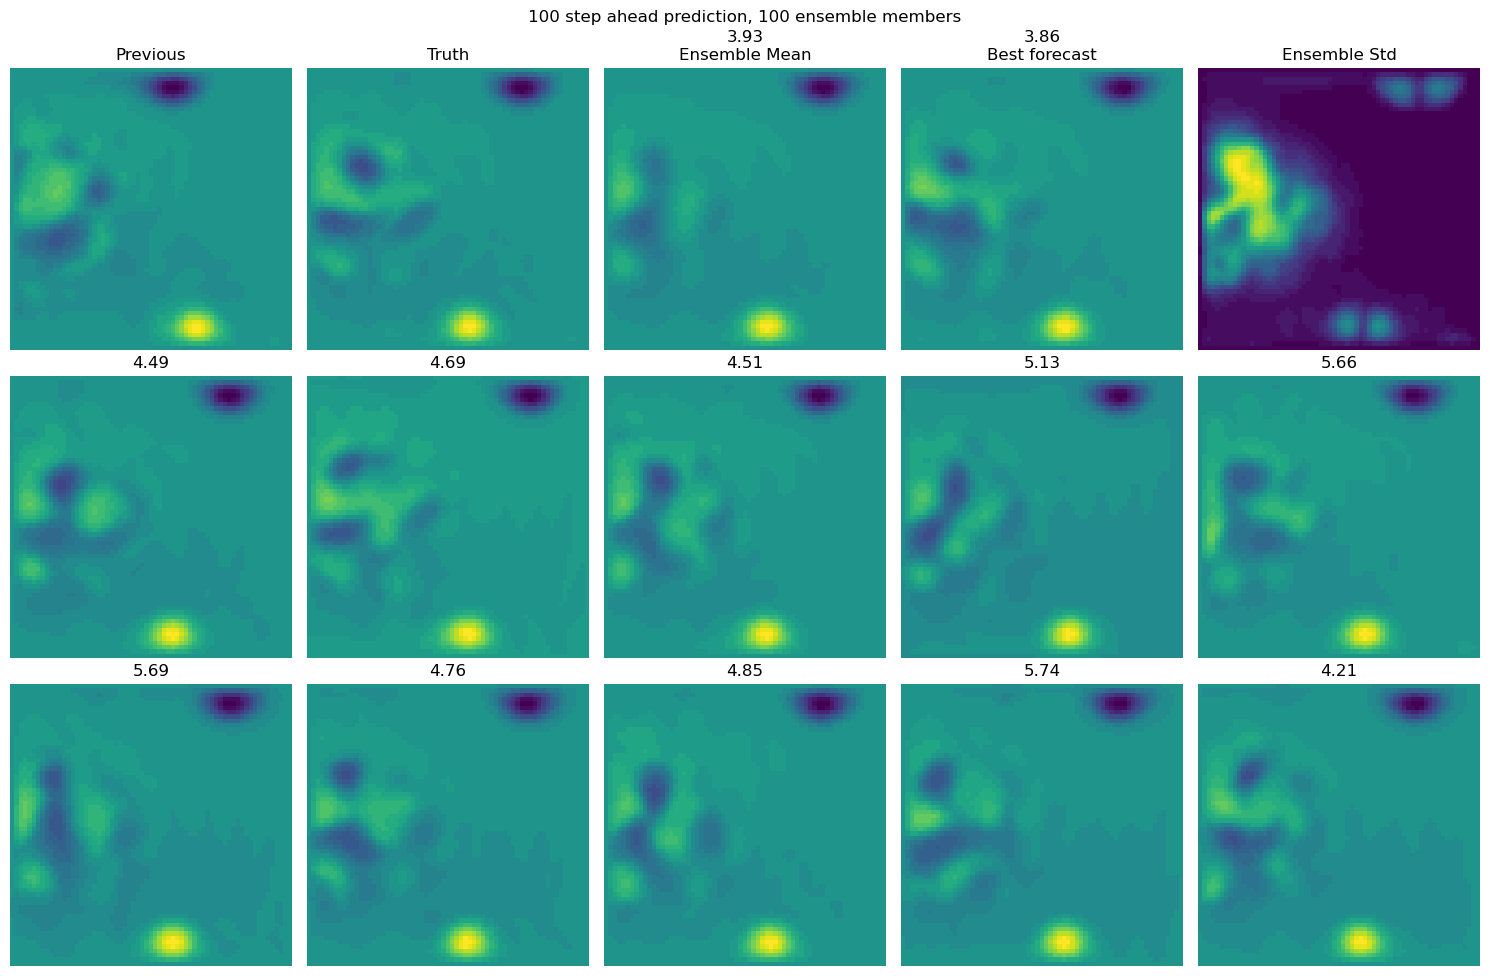

In [12]:
# Standard plot of ensembles

def ensemble_plot(model, selected_loader=val_loader, n_ens=10, sampler_fn=heun_sampler):
    
    lead_time = selected_loader.dataset.lead_time
    predicted_unnormalized, current_unnormalized, previous_unnormalized = generate_ensemble_from_single_random(model, n_ens, selected_loader, sampler_fn=sampler_fn)

    ensemble_mean = predicted_unnormalized.mean(dim=0, keepdim=True)
    ensemble_rmses = calculate_RMSE(predicted_unnormalized, current_unnormalized).flatten()
    ensemble_skill = calculate_RMSE(ensemble_mean, current_unnormalized).item()
    ensemble_std = predicted_unnormalized.std(dim=0)

    best_forecast = predicted_unnormalized[np.argmin(ensemble_rmses)]
    best_rmse = ensemble_rmses[np.argmin(ensemble_rmses)]

    def plot_image(ax, image, title):
        image = image.cpu().detach().numpy().reshape((65,65))
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        ax.axis('off')

    plt.set_cmap('viridis')
    no_ens_rows = 2

    fig, axes = plt.subplots(1+no_ens_rows, 5, figsize=(15, 10))
    fig.suptitle(f'{lead_time} step ahead prediction, {n_ens} ensemble members')

    plot_image(axes[0,0], previous_unnormalized, "Previous")
    plot_image(axes[0,1], current_unnormalized, "Truth")
    plot_image(axes[0,2], ensemble_mean, f"{ensemble_skill:.2f}\nEnsemble Mean")
    plot_image(axes[0,3], best_forecast, f"{best_rmse:.2f}\nBest forecast")
    plot_image(axes[0,4], ensemble_std, "Ensemble Std")

    count = 0
    for i in range(no_ens_rows):
        for j in range(5):
            plot_image(axes[1+i,j], predicted_unnormalized[count], f"{ensemble_rmses[count]:.2f}")
            count+=1
    
    plt.tight_layout()
    plt.show()
    
    return ensemble_rmses, ensemble_skill


ensemble_rmses, ensemble_skill = ensemble_plot(model, selected_loader=val_loader, n_ens=100, sampler_fn=heun_sampler)


### Forecast at single future time like GenCast

In [36]:
# We assume that the split results in same distance between all.
# Otherwise it becomes wrong when we flip it.

# Way to load a single trajectory. Only uses 1 batch.
t_kmin = 0
t_kmax = 150
t_d = 25

k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **QG_kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for previous, current, time_label in (val_time_series_loader):
        current = current.to(device).permute(1,0,2,3)

        current_last = current[-1].unsqueeze(0).repeat(current.shape[0]-1, 1, 1, 1)
        current_latent = autoencoder.encoder(current_last)

        time_labels = time_label[0].flip([0])[:-1].to(device)
        
        previous_latent = autoencoder.encoder(current[:-1])
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        target_latent =  (current_latent - previous_latent) / scaling
        
        class_labels = previous_latent

        current_unnormalized = current_last * std_data + mean_data

        break

In [37]:
n_ens = 4

ensembles = []
with torch.no_grad():

    for i in range(n_ens):    
        latents = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_latent = previous_latent + predicted_residuals * scaling

        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data

        ensembles.append(predicted_unnormalized)

ensembles = torch.stack(ensembles)
ens_mean = ensembles.mean(dim=0)
ens_std = ensembles.std(dim=0)


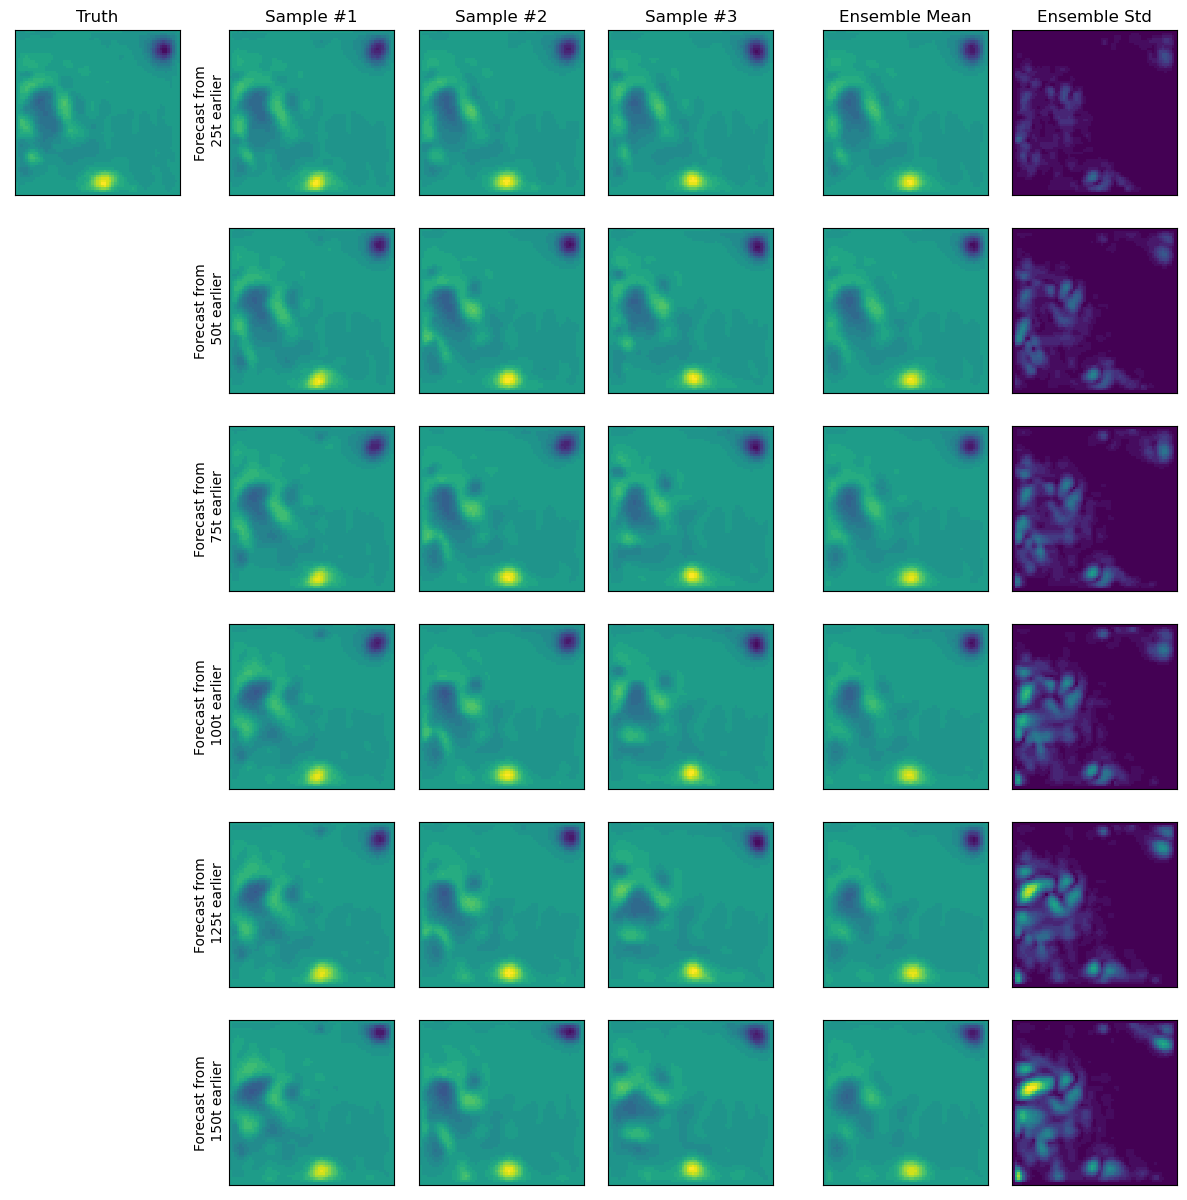

In [41]:
import matplotlib.gridspec as gridspec

def plot_image(ax, image, title=None, vmin=None, vmax=None):
    image = image.cpu().detach().numpy().reshape((65,65))
    ax.imshow(image,vmin=vmin, vmax=vmax, cmap=cmap, interpolation='none')
    if title!=None:
        ax.set_title(title)
    #ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])

no_ens_rows = ensembles.shape[1]

cols = 6 + 2
col_width_ratios = [1, 0, 1, 1, 1, 0, 1, 1]
gs = gridspec.GridSpec(no_ens_rows, cols, width_ratios=col_width_ratios)
fig = plt.figure(figsize=(15,15))

axes = np.empty((no_ens_rows, cols), dtype=object)
for i in range(no_ens_rows):
    for j in range(cols):
        axes[i,j] = plt.subplot(gs[i,j])

max_value = ensembles[:3].max()
min_value = ensembles[:3].min()

plot_image(axes[0,0], current_unnormalized[-1], "Truth", vmin=min_value, vmax=max_value)

for j in range(1, 4):
    axes[0,j+1].set_title(f"Sample #{j}")
axes[0,6].set_title("Ensemble Mean")
axes[0,7].set_title(f"Ensemble Std")


for i in range(no_ens_rows):
    if i > 0:
        axes[i,0].axis('off')
    axes[i,1].text(1.18,0.5, f"Forecast from\n {time_labels[-(i+1)].item()}t earlier", horizontalalignment='center', verticalalignment='center', rotation=90, transform=axes[i,0].transAxes)
    
    axes[i,1].axis('off')
    axes[i,5].axis('off')

    for j in range(1, 4):
        plot_image(axes[i,j+1], ensembles[j,-(i+1)], vmin=min_value, vmax=max_value)
    plot_image(axes[i,6], ens_mean[-(i+1)], vmin=min_value, vmax=max_value)
    plot_image(axes[i,7], ens_std[-(i+1)], vmin=0, vmax=ens_std.max())


plt.savefig('large_ensemble_plot.pdf', dpi=100, format='pdf', bbox_inches='tight')#, pad_inches=0.1, transparent=True, quality=95, optimize=True)
plt.show()

### Forecast over lead time

In [43]:
t_kmin = 25
t_kmax = 150
t_d = 25

k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **QG_kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for previous, current, time_label in (val_time_series_loader):
        current = current.to(device).permute(1,0,2,3)
        previous = previous.to(device)

        current_latent = autoencoder.encoder(current)

        time_labels = time_label[0].to(device)
        
        previous_latent = autoencoder.encoder(previous)
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        target_latent =  (current_latent - previous_latent) / scaling
        
        class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

        current_unnormalized = current * std_data + mean_data
        previous_unnormalized = previous * std_data + mean_data

        break

In [45]:
n_ens = 10

ensembles = []
with torch.no_grad():

    for i in range(n_ens):    
        latents = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_latent = previous_latent + predicted_residuals * scaling

        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data

        ensembles.append(predicted_unnormalized)

ensembles = torch.stack(ensembles)
ens_mean = ensembles.mean(dim=0)
ens_std = ensembles.std(dim=0)


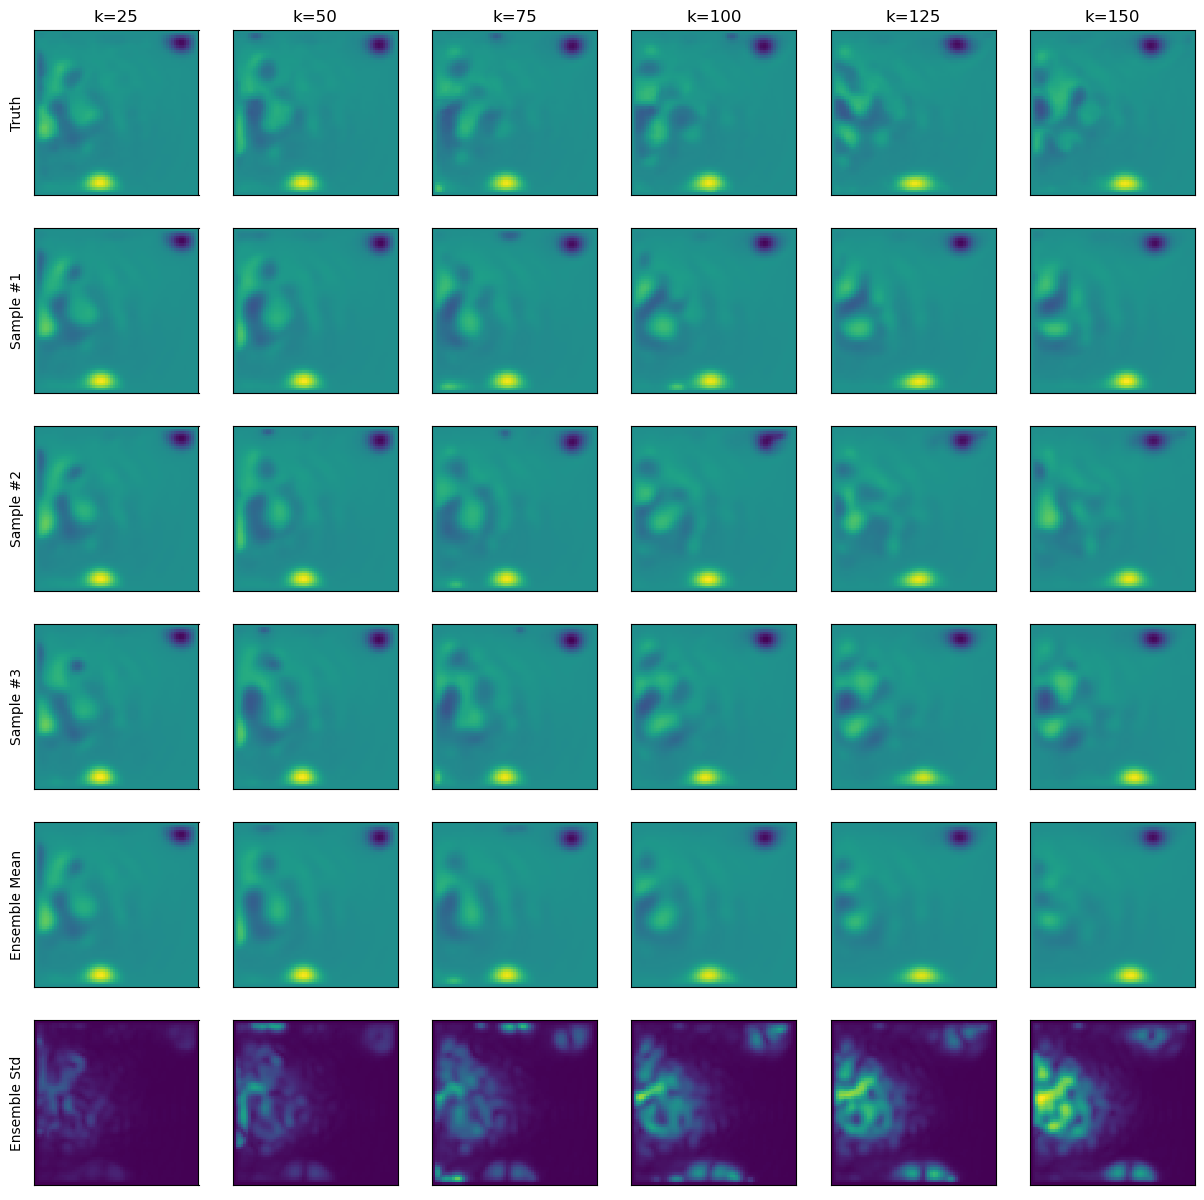

In [46]:
import matplotlib.gridspec as gridspec


def plot_image(ax, image, title=None, vmin=None, vmax=None, cmap='viridis'):
    image = image.cpu().detach().numpy().reshape((65,65))
    ax.imshow(image,vmin=vmin, vmax=vmax, cmap=cmap, interpolation='none')
    if title!=None:
        ax.set_title(title)
    #ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])

def place_text(ax, text):
    ax.text(-0.1,0.5, text, horizontalalignment='center', verticalalignment='center', rotation=90, transform=ax.transAxes)

max_value = max([ensembles[:3].max(), current_unnormalized.max(), ens_mean.max()])
min_value = min([ensembles[:3].min(), current_unnormalized.min(), ens_mean.min()])

no_ens_rows =  ensembles.shape[1]

cols = current_unnormalized.shape[0]

gs = gridspec.GridSpec(no_ens_rows, cols)#, width_ratios=col_width_ratios)

fig = plt.figure(figsize=(15,15))#, constrained_layout=True)


axes = np.empty((no_ens_rows, cols), dtype=object)
for i in range(no_ens_rows):
    for j in range(cols):
        axes[i,j] = plt.subplot(gs[i,j])


place_text(axes[0,0], "Truth")
place_text(axes[1,0], "Sample #1")
place_text(axes[2,0], "Sample #2")
place_text(axes[3,0], "Sample #3")
place_text(axes[4,0], "Ensemble Mean")
place_text(axes[5,0], "Ensemble Std")

for i in range(cols):
    

    plot_image(axes[0,i], current_unnormalized[i], f'k={time_labels[i]}', vmin=min_value, vmax=max_value)
    
    for j in range(1, 4):
        plot_image(axes[j, i], ensembles[j-1, i], vmin=min_value, vmax=max_value)
    
    plot_image(axes[4,i], ens_mean[i], vmin=min_value, vmax=max_value)
    plot_image(axes[5,i], ens_std[i], vmin=0, vmax=ens_std.max(), cmap='viridis')


plt.savefig('long_ensemble_plot.pdf', dpi=100, format='pdf', bbox_inches='tight')#, pad_inches=0.1, transparent=True, quality=95, optimize=True)
plt.show()



### RMSE over time

In [ ]:
def rmse_plot(model, n_ens=1, n_batches=1, selected_loader=val_loader, sampler_fn=heun_sampler):
    model.eval()

    result = {}
    result['rmse_model'] = np.zeros(n_batches*batch_size)
    result['rmse_clim'] = np.zeros(n_batches*batch_size)

    with torch.no_grad():
        for count, (previous, current, time_label) in enumerate(tqdm(selected_loader)):
            current = current.to(device)
            time_label = time_label.to(device)
            if count >= n_batches:
                break

            predicted_unnormalized = generate_ensemble_from_batch(model, previous, time_label[0], n_ens=n_ens, sampler_fn=sampler_fn)

            current_unnormalized = current * std_data + mean_data
            previous_unnormalized = previous * std_data + mean_data

            #  Note that this is kind of cheating since we are using the validation set to calculate the climatology.
            #  More realistic if we have a larger batch size.
            #climatology = previous_unnormalized.mean(dim=0, keepdim=True)

            ensemble_mean = predicted_unnormalized.mean(dim=0)

            rmse_model = calculate_RMSE(ensemble_mean, current_unnormalized)
            rmse_clim = calculate_RMSE(climatology, current_unnormalized)

            result['rmse_model'][count*batch_size:count*batch_size+rmse_model.size] = rmse_model.flatten()
            result['rmse_clim'][count*batch_size:count*batch_size+rmse_model.size] = rmse_clim.flatten()

    return result

0
1


  0%|          | 0/104991 [00:00<?, ?it/s]C:\Users\svart\AppData\Local\Temp\ipykernel_32416\542238765.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_latent = class_labels + predicted_residuals * residual_scaling(torch.tensor(lead_time))
  0%|          | 1/104991 [00:03<93:17:23,  3.20s/it]


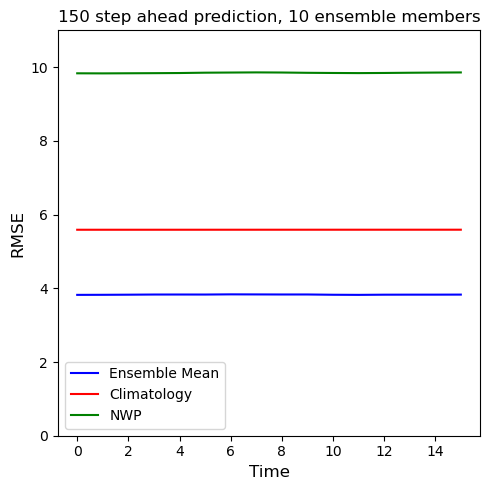

In [ ]:
lead_time = 150
batch_size = 16
val_dataset = QGDataset(lead_time=lead_time, dataset_mode='val', **QG_kwargs)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

n_batches = 1

# NWP

n_val = 210000
nwp_data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_LRES_{iterations}_n_{n_val}_k_{lead_time}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_LRES_{iterations}_n_{n_val}_k_{lead_time}.npy')
nwp_dataset = NWPDataset(nwp_data_path, n_val=n_val, spacing=spacing, device=device)
nwp_loader = DataLoader(nwp_dataset, batch_size=batch_size, shuffle=False)
nwp_skill = calculate_nwp_skill(n_batches=n_batches)

# Climate and skill
climatology = calculate_climatology(train_loader, n_batches=n_batches)

n_ens = 10
running_mean = 100

result = rmse_plot(model, n_ens, n_batches, selected_loader=val_loader, sampler_fn=heun_sampler)

rmse_model, rmse_clim = result['rmse_model'], result['rmse_clim']
rmse_nwp = nwp_skill[:n_batches*batch_size]

plt.figure(figsize=(5,5))
plt.title(f'{lead_time} step ahead prediction, {n_ens} ensemble members')
plt.plot(uniform_filter1d(rmse_model, size=running_mean), label='Ensemble Mean', color='b')
plt.plot(uniform_filter1d(rmse_clim, size=running_mean), label='Climatology', color='r')
plt.plot(uniform_filter1d(rmse_nwp, size=running_mean), label='NWP', color='g')
plt.ylim(0,11)
plt.xlabel('Time', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def rmse_density_plot(ensemble_rmses, ensemble_skill):
    plt.figure(figsize=(6,6))
    plt.hist(ensemble_rmses, bins=100)
    plt.axvline(ensemble_skill, color='red', linestyle='--')
    plt.xlabel('Ensemble RMSEs')
    plt.ylabel('Density')
    plt.title('Density Plot of Ensemble RMSEs')
    plt.show()

rmse_density_plot(ensemble_rmses, ensemble_skill)

### Spread vs time

In [ ]:
# Fixed k sampling
# Way to load a single trajectory. Only uses 1 batch.
t_kmin = 10
t_kmax = 150
t_d = 10
k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **QG_kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

n_batches = 1

spread_list = []
skill_list = []
ratio_list = []

for i in tqdm(range(n_batches)):
        
    model.eval()  # Set model to evaluation mode

    n_ens = 10

    with torch.no_grad():
        for previous, current, time_label in (val_time_series_loader):
            current = current.to(device).permute(1,0,2,3)
            previous = previous.to(device)

            current_latent = autoencoder.encoder(current)

            time_labels = time_label[0].to(device)
            
            previous_latent = autoencoder.encoder(previous)
            
            scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
            target_latent =  (current_latent - previous_latent) / scaling
            
            class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

            current_unnormalized = current * std_data + mean_data
            previous_unnormalized = previous * std_data + mean_data

            break


    ensembles = []
    with torch.no_grad():
        for i in tqdm(range(n_ens)):    
            latents = torch.randn_like(class_labels[0].unsqueeze(0), device=device).repeat(class_labels.shape[0], 1, 1, 1)

            predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
            predicted_latent = previous_latent + predicted_residuals * scaling

            predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

            predicted_unnormalized = predicted * std_data + mean_data

            ensembles.append(predicted_unnormalized)

    ensembles = torch.stack(ensembles)
    ens_mean = ensembles.mean(dim=0)


    spreads = []
    skills = []

    for i in range(len(time_labels)):
        truth = current_unnormalized[i]
        predicted = ens_mean[i]
        ensemble = ensembles[:, i]

        skill, spread,_ = calculate_skill_and_spread_score(ensemble, truth)
        spreads.append(spread[0])
        skills.append(skill[0])
    
    spread_list.append(spreads)
    skill_list.append(skills)
    ratio_list.append(np.array(spreads)/np.array(skills))

spread_list = np.array(spread_list)
skill_list = np.array(skill_list)
ratio_list = np.array(ratio_list)
time_labels = time_labels.cpu().detach().numpy()

100%|██████████| 1/1 [00:19<00:00, 19.67s/it]


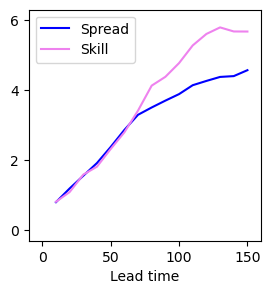

In [ ]:
spreads = spread_list.mean(axis=0)
skills = skill_list.mean(axis=0)

plt.figure(figsize=(3,3))
plt.xlabel('Lead time')

plt.xticks([0,50,100,150])
plt.xlim([-10,160])
plt.yticks([0,2,4,6])
plt.ylim(0-0.3, 6+0.3)

plt.plot(time_labels, uniform_filter1d(spreads, size=1), label='Spread', color='#0000FF')
plt.plot(time_labels, uniform_filter1d(skills, size=1), label='Skill', color='#EE82EE')

plt.legend()

plt.savefig(f'skill_spread_{lead_time}_{n_ens}.pdf', dpi=100, format='pdf', bbox_inches='tight')

### Rank Histogram

In [74]:
def generate_ensembles(n_ens, n_batches, selected_loader=val_loader):
    model.eval()

    ensembles = []
    truths = []

    with torch.no_grad():
        for count, (previous, current, time_label) in enumerate(tqdm(selected_loader, total=n_batches)):
            if count >= n_batches:
                break
            current = current.to(device)

            predicted_unnormalized = generate_ensemble_from_batch(model, previous, time_label[0], n_ens=n_ens, sampler_fn=heun_sampler)
            current_unnormalized = current * std_data + mean_data

            ensembles.append(predicted_unnormalized)
            truths.append(current_unnormalized)

    ensembles = torch.cat(ensembles, dim=1)
    truths = torch.cat(truths, dim=0)
    return ensembles, truths


lead_time = 150
batch_size = 16
val_dataset = QGDataset(lead_time=lead_time, dataset_mode='val', **QG_kwargs)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

n_ens = 1
n_batches = 1

ensembles, truths = generate_ensembles(n_ens, n_batches, selected_loader=val_loader)

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\svart\AppData\Local\Temp\ipykernel_32416\542238765.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_latent = class_labels + predicted_residuals * residual_scaling(torch.tensor(lead_time))
100%|██████████| 1/1 [00:03<00:00,  3.09s/it]


In [75]:
# Rank Histogram

def calculate_rank(predicted, target):
    ranks = (target[None, :] < predicted).sum(axis=0)
    return ranks

def rank_histogram(pixel, ensembles, truths):

    pixel_x, pixel_y = pixel
    
    ensemble = ensembles[:, :, 0, pixel_x, pixel_y]
    target = truths[:, 0, pixel_x, pixel_y]

    rank = calculate_rank(ensemble, target)

    return rank.cpu().detach().numpy()

torch.Size([16, 1, 65, 65])

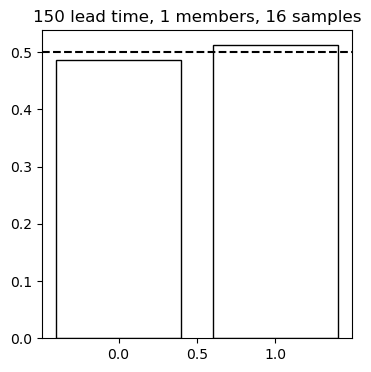

In [77]:
ranks = np.zeros(n_ens+1)
for i in range(0, truths.shape[2]):
    for j in range(0, truths.shape[3]):
        pixel = (i,j)
        rank = rank_histogram(pixel, ensembles, truths)
        freq = np.bincount(rank, minlength=n_ens+1)
        ranks += freq


plt.figure(figsize=(4,4))
plt.title(f'{lead_time} lead time, {n_ens} members, {n_batches*batch_size} samples')
plt.bar(np.arange(n_ens+1), ranks/(sum(ranks)), facecolor='white', edgecolor='black')
plt.axhline(1/(n_ens+1), color='k', linestyle='--')

In [78]:
# New look

ranks = np.zeros(n_ens+1)
for i in range(0, 65):
    for j in range(0, 65):
        pixel = (i,j)
        rank = rank_histogram(pixel, ensembles, truths)
        freq = np.bincount(rank, minlength=n_ens+1)
        ranks += freq

print(f'{n_ens} members, {n_batches*batch_size} samples')
plt.figure(figsize=(3,3))
plt.title(f'k={k}')
plt.plot(np.linspace(0,1,n_ens+1), ranks*(n_ens+1)/(sum(ranks)), color='black')
plt.xlabel('Rank (normalized)')
plt.ylabel('Frequency')
plt.ylim(-0.1,2.1)
plt.yticks([0,0.5,1,1.5,2])
plt.xticks([0,0.25,0.5,0.75,1])
plt.axhline(1, color='k', linestyle='--', alpha=0.5)

plt.savefig(f'rank_histogram_{k}_{n_ens}_{n_batches*batch_size}.pdf', dpi=100, format='pdf', bbox_inches='tight')#, pad_inches=0.1, transparent=True, quality=95, optimize=True)

1 members, 16 samples


NameError: name 'k' is not defined

<Figure size 300x300 with 0 Axes>

(48, 19)


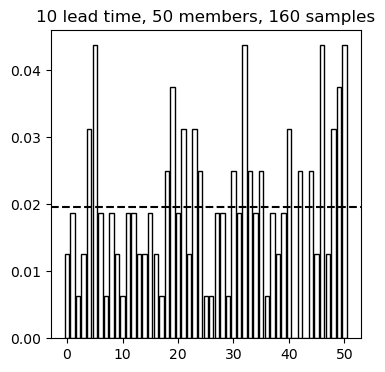

In [ ]:
pixel = (np.random.randint(0, 65), np.random.randint(0, 65))
print(pixel)
#pixel = (1,33)
ranks = np.zeros(n_ens+1)
rank = rank_histogram(pixel, ensembles, truths)
freq = np.bincount(rank, minlength=n_ens+1)
ranks += freq

plt.figure(figsize=(4,4))
plt.title(f'{k} lead time, {n_ens} members, {n_batches*batch_size} samples')
plt.bar(np.arange(n_ens+1), ranks/(sum(ranks)), facecolor='white', edgecolor='black')
plt.axhline(1/(n_ens+1), color='k', linestyle='--')

# **Plots Above are done**

### Autoreg

In [68]:
t_kmin = 1
t_kmax = 150
t_d = 10

k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **QG_kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

max_count = 0

model.eval()  # Set model to evaluation mode

count = 0

with torch.no_grad():
    for previous, current, time_label in (val_time_series_loader):
        count += 1

        if count < max_count:
            continue

        current = current.to(device).permute(1,0,2,3)
        previous = previous.to(device)

        current_latent = autoencoder.encoder(current)

        time_labels = time_label[0].to(device)
        previous_latent = autoencoder.encoder(previous)
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        target_latent =  (current_latent - previous_latent) / scaling
        
        class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

        current_unnormalized = current * std_data + mean_data
        previous_unnormalized = previous * std_data + mean_data

        break

In [37]:
with torch.no_grad():
        time_labels = torch.arange(1,151,1,  device=device, dtype=int)
        
        class_labels = previous_latent.repeat(time_labels.shape[0], 1, 1, 1)
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        

In [69]:
n_ens = 10

latents_list = []
ensembles_list = []

for i in range(n_ens): 
    latents = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
    latents_list.append(latents)

latents_list = torch.stack(latents_list)

In [70]:
roll_outs = len(time_labels)

ensembles = []
ensembles_ar = []
with torch.no_grad():

    for i in range(n_ens):
        # Direct  
        #latents = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
        latents = latents_list[i]
        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_latent = previous_latent + predicted_residuals * scaling
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))
        predicted_unnormalized = predicted * std_data + mean_data
        ensembles.append(predicted_unnormalized)

    """ # Autoreg
    latents = latents_list[:,0]
    prev_pred = class_labels[0].repeat(n_ens, 1, 1, 1)
    time_label = time_labels[0].repeat(n_ens)
    scale = residual_scaling(time_label).view(-1, 1, 1, 1)

    for i in range(roll_outs):
        #latentss = torch.randn_like(latents, device=device)
        predicted_ar_residuals = heun_sampler(model, latents, prev_pred, time_label/kmax, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_ar_latent = prev_pred + predicted_ar_residuals * scale
        
        predicted_ar = autoencoder.decoder(predicted_ar_latent.to(torch.float32))
        
        prev_pred = predicted_ar_latent
        
        predicted_unnormalized_ar = predicted_ar * std_data + mean_data
        ensembles_ar.append(predicted_unnormalized_ar)"""


ensembles = torch.stack(ensembles)
#ensembles_ar = torch.stack(ensembles_ar).permute(1,0,2,3,4)

ens_mean = ensembles.mean(dim=0)
ens_std = ensembles.std(dim=0)


TypeError: list indices must be integers or slices, not tuple

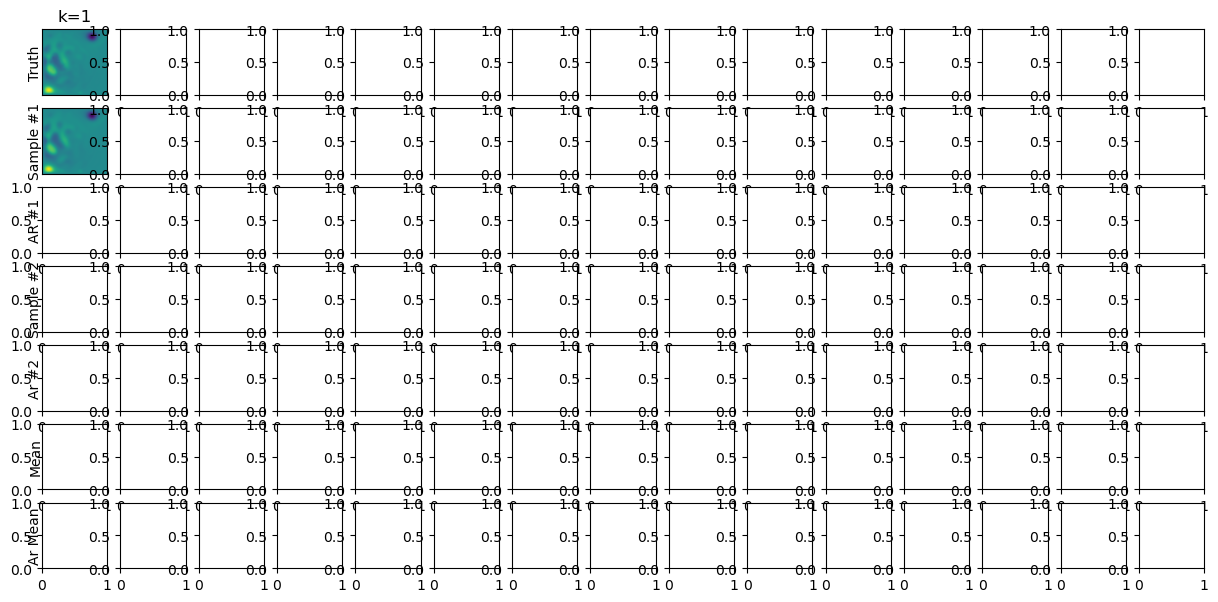

In [71]:
import matplotlib.gridspec as gridspec


def plot_image(ax, image, title=None, vmin=None, vmax=None, cmap='viridis'):
    image = image.cpu().detach().numpy().reshape((65,65))
    ax.imshow(image,vmin=vmin, vmax=vmax, cmap=cmap)#, interpolation='none')
    if title!=None:
        ax.set_title(title)
    #ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])

def place_text(ax, text):
    ax.text(-0.1,0.5, text, horizontalalignment='center', verticalalignment='center', rotation=90, transform=ax.transAxes)

max_value = max([ensembles[:3].max(), current_unnormalized.max(), ens_mean.max()])
min_value = min([ensembles[:3].min(), current_unnormalized.min(), ens_mean.min()])

#plt.set_cmap('viridis')
no_ens_rows = 7

cols = current_unnormalized.shape[0]

gs = gridspec.GridSpec(no_ens_rows, cols)#, width_ratios=col_width_ratios)

fig = plt.figure(figsize=(15, 7))#, constrained_layout=True)


axes = np.empty((no_ens_rows, cols), dtype=object)
for i in range(no_ens_rows):
    for j in range(cols):
        axes[i,j] = plt.subplot(gs[i,j])


place_text(axes[0,0], "Truth")
place_text(axes[1,0], "Sample #1")
place_text(axes[2,0], "AR #1")
place_text(axes[3,0], "Sample #2")
place_text(axes[4,0], "Ar #2")
place_text(axes[5,0], "Mean")
place_text(axes[6,0], "Ar Mean")


for i in range(cols):

    plot_image(axes[0, i], current_unnormalized[i], f'k={time_labels[i]}', vmin=min_value, vmax=max_value)
    
    plot_image(axes[1, i], ensembles[0, i], vmin=min_value, vmax=max_value)
    plot_image(axes[2, i], ensembles_ar[0, i], vmin=min_value, vmax=max_value)
    plot_image(axes[3, i], ensembles[1, i], vmin=min_value, vmax=max_value)
    plot_image(axes[4, i], ensembles_ar[1, i], vmin=min_value, vmax=max_value)
    plot_image(axes[5, i], ensembles[:, i].mean(axis=0), vmin=min_value, vmax=max_value)
    plot_image(axes[6, i], ensembles_ar[:, i].mean(axis=0), vmin=min_value, vmax=max_value)


plt.savefig('ar_ensemble_plot.pdf', dpi=100, format='pdf', bbox_inches='tight')#, pad_inches=0.1, transparent=True, quality=95, optimize=True)
plt.show()

In [41]:
ks = torch.arange(val_time_series_dataset.kmin, val_time_series_dataset.kmax+1, val_time_series_dataset.d,  device=device, dtype=int)

spreads = []
skills = []
ratios = []
rmses = []

spreads_ar = []
skills_ar = []
ratios_ar = []
rmses_ar = []

ens_mean = ensembles.mean(dim=0)
#ens_mean_ar = ensembles_ar.mean(dim=0)

for i in range(len(ks)):
    truth = current_unnormalized[(ks[i]-kmin)//d]
    predicted = ens_mean[(ks[i]-kmin)//d]
    ensemble = ensembles[:, (ks[i]-kmin)//d]

    skill, spread,_ = calculate_skill_and_spread_score(ensemble, truth)
    rmse = calculate_RMSE(ensemble, truth)

    spreads.append(spread[0])
    skills.append(skill[0])
    ratios.append(spread[0]/skill[0])
    rmses.append(rmse)

    #predicted = ens_mean_ar[(ks[i]-kmin)//d]
    #ensemble = ensembles_ar[:, (ks[i]-kmin)//d]

    skill, spread,_ = calculate_skill_and_spread_score(ensemble, truth)
    rmse = calculate_RMSE(ensemble, truth)

    spreads_ar.append(spread[0])
    skills_ar.append(skill[0])
    ratios_ar.append(spread[0]/skill[0])
    rmses_ar.append(rmse)

ks = ks.cpu().detach().numpy()

rmses = np.array(rmses)[:,:,0]
rmses_ar = np.array(rmses_ar)[:,:,0]


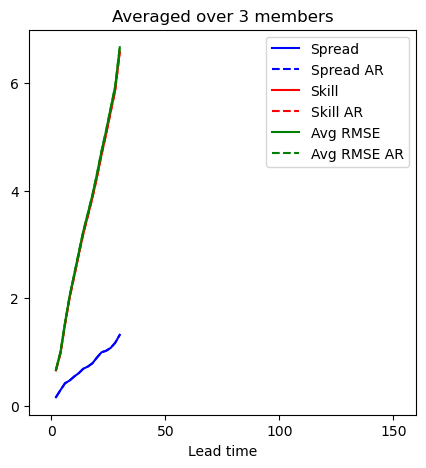

In [ ]:


plt.figure(figsize=(5,5))
plt.title(f'Averaged over {n_ens} members')
plt.xlabel('Lead time')

plt.xticks([0,50,100,150])
plt.xlim([-10,160])
plt.yticks([0,2,4,6,8])
#plt.ylim(0-0.3, 7+0.3)

plt.plot(ks, uniform_filter1d(spreads, size=1), label='Spread', color='blue')
plt.plot(ks, uniform_filter1d(spreads_ar, size=1), label='Spread AR', color='blue', linestyle='--')

plt.plot(ks, uniform_filter1d(skills, size=1), label='Skill', color = 'red')
plt.plot(ks, uniform_filter1d(skills_ar, size=1), label='Skill AR', color='red', linestyle='--')

plt.plot(ks, uniform_filter1d(np.mean(rmses,axis=1), size=1), label='Avg RMSE', color='green')
plt.plot(ks, uniform_filter1d(np.mean(rmses_ar,axis=1), size=1), label='Avg RMSE AR', color='green', linestyle='--')

plt.legend()

plt.savefig(f'skill_spread_{k}_{n_ens}.pdf', dpi=100, format='pdf', bbox_inches='tight')

In [45]:
dt = len(time_labels)
truth = current_unnormalized.cpu().detach().numpy().reshape((-1, 65,65))
#ensembles = ensembles.cpu().detach().numpy().reshape((n_ens, dt, 65,65))
truth_nwp = nwp_current_unnormalized.cpu().detach().numpy().reshape((-1, 65,65))
#ensembles_ar = ensembles_ar.cpu().detach().numpy().reshape((n_ens, dt, 65,65))

ens_mean = ensembles.mean(axis=0)
ens_stds = ensembles.std(axis=0)

#ens_mean_ar = ensembles_ar.mean(axis=0)

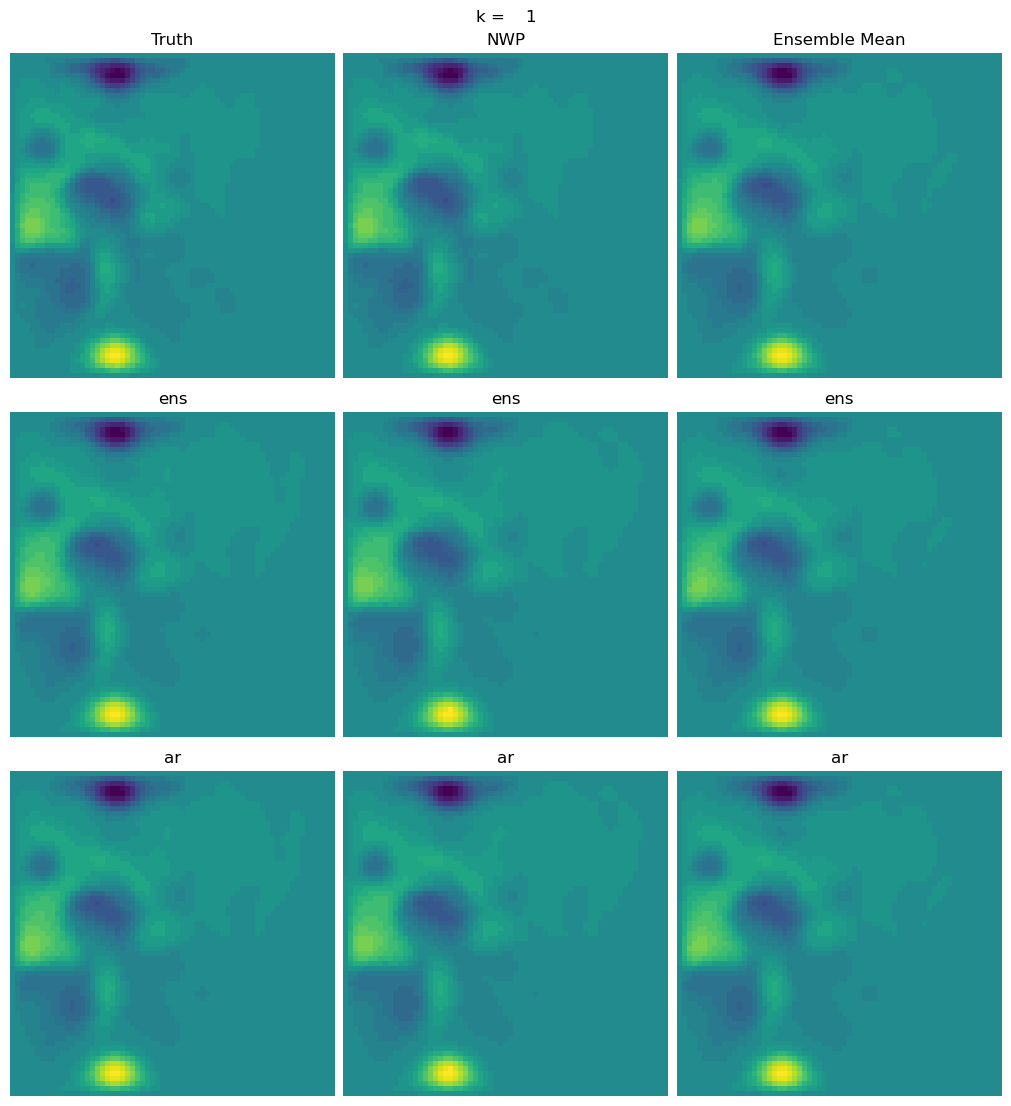

In [48]:
%matplotlib inline
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

cmap = plt.cm.get_cmap('viridis', 30)


fig, axes = plt.subplots(3,3, figsize=(10,11), constrained_layout=True)
#fig, axes = plt.subplots(2,3, figsize=(10,7), constrained_layout=True)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    ax.axis('off')

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')
title3 = axes[0,2].set_title('')

images = []
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        pass
        images.append(ax.imshow(truth[0], cmap=cmap))
    elif i == 1:
        #images.append(ax.imshow(ens_mean_ar[0]))
        images.append(ax.imshow(truth_nwp[0], cmap=cmap))

        #images.append(ax.imshow(ens_stds[0], vmin=0, vmax = ens_stds.max()))
        pass
        #images.append(ax.imshow(decoded_truth[0]))

    elif i == 2:
        images.append(ax.imshow(ens_mean[0], cmap=cmap))
    elif i<6:
        images.append(ax.imshow(ensembles[i-5,0], cmap=cmap))
        ax.set_title('ens')
    else:
        pass
        images.append(ax.imshow(ensembles[i-8,0], cmap=cmap))
        #images.append(ax.imshow(ensembles_ar[i-8,0]))
        ax.set_title('ar')

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i == 0:
            pass
            im.set_array(truth[n])
        elif i == 1:
            pass
            im.set_array(truth_nwp[n])
            #im.set_array(ens_mean_ar[n])
            #im.set_array(ens_stds[n])
            #im.set_array(decoded_truth[n])
        elif i == 2:
            im.set_array(ens_mean[n])
        elif i < 6:
            im.set_array(ensembles[i-5,n])
        else:
            pass
            im.set_array(ensembles[i-8,n])


    txt_title.set_text('k = {0:4d}'.format(d*n+kmin))
    title1.set_text('Truth')
    #title2.set_text('Decoded Truth')
    #title2.set_text('Standard Deviation')
    title2.set_text('NWP')
    title3.set_text('Ensemble Mean')

    return images

#plt.tight_layout(rect=[0, 0, 1, 0.95])

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=dt, interval=50)

#anim.save('animation.gif', writer='imagemagick', fps=30)
HTML(anim.to_html5_video())

In [165]:
anim.save('animationVeryWrong.gif', writer='imagemagick', fps=30)

In [ ]:
# NWP

%matplotlib inline
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')


fig, axes = plt.subplots(3,3, figsize=(10,11), constrained_layout=True)
#fig, axes = plt.subplots(2,3, figsize=(10,7), constrained_layout=True)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    ax.axis('off')

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')
title3 = axes[0,2].set_title('')

images = []
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        pass
        images.append(ax.imshow(truth[0]))
    elif i == 1:
        #images.append(ax.imshow(ens_mean_ar[0]))
        images.append(ax.imshow(ens_stds[0], vmin=0, vmax = ens_stds.max()))
        pass
        #images.append(ax.imshow(decoded_truth[0]))

    elif i == 2:
        images.append(ax.imshow(ens_mean[0]))
    elif i<6:
        images.append(ax.imshow(ensembles[i-5,0]))
        ax.set_title('ens')
    else:
        pass
        images.append(ax.imshow(ensembles[i-8,0]))
        #images.append(ax.imshow(ensembles_ar[i-8,0]))
        ax.set_title('ar')

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i == 0:
            pass
            #im.set_array(truth[n])
        elif i == 1:
            pass
            #im.set_array(ens_mean_ar[n])
            #im.set_array(ens_stds[n])
            #im.set_array(decoded_truth[n])
        elif i == 2:
            im.set_array(ens_mean[n])
        elif i < 6:
            im.set_array(ensembles[i-5,n])
        else:
            pass
            #im.set_array(ensembles_ar[i-8,n])


    txt_title.set_text('k = {0:4d}'.format(d*n+kmin))
    title1.set_text('Truth')
    #title2.set_text('Decoded Truth')
    #title2.set_text('Standard Deviation')
    title2.set_text('Ensemble Mean AR')
    title3.set_text('Ensemble Mean')

    return images

#plt.tight_layout(rect=[0, 0, 1, 0.95])

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=dt, interval=100)

#anim.save('animation.gif', writer='imagemagick', fps=30)
HTML(anim.to_html5_video())

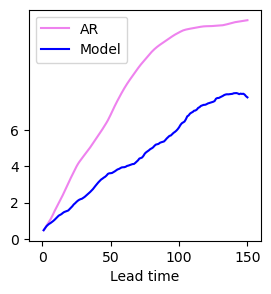

In [205]:

plt.figure(figsize=(3,3))
plt.xlabel('Lead time')

plt.xticks([0,50,100,150])
plt.xlim([-10,160])
plt.yticks([0,2,4,6])
#plt.ylim(0-0.3, 7+0.3)

for i in range(n_ens):
    pass
    #plt.plot(ks, uniform_filter1d(rmses[:,i], size=1), label='Model', color='#0000FF')
    #plt.plot(ks, uniform_filter1d(rmses_ar[:,i], size=1), label='AR', color='#EE82EE')

plt.plot(ks, uniform_filter1d(np.mean(rmses_ar,axis=1), size=1), label='AR', color='#EE82EE')
plt.plot(ks, uniform_filter1d(np.mean(rmses,axis=1), size=1), label='Model', color='#0000FF')

plt.legend()
plt.savefig(f'skill_spread_{k}_{n_ens}.pdf', dpi=100, format='pdf', bbox_inches='tight')

### New idea based on adding gaussians

In [82]:
model.eval()  # Set model to evaluation mode


with torch.no_grad():
    for previous, current in (val_time_series_loader):
        current = current.to(device).permute(1,0,2,3)
        previous = previous.to(device)

        current_latent = autoencoder.encoder(current)

        time_labels = torch.arange(val_time_series_dataset.kmin, val_time_series_dataset.kmax+1, val_time_series_dataset.d,  device=device, dtype=int)
        
        previous_latent = autoencoder.encoder(previous)
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        
        class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

        current_unnormalized = current * std_data + mean_data
        previous_unnormalized = previous * std_data + mean_data
        decoded_current_unnormalized = autoencoder.decoder(current_latent) * std_data + mean_data

        break

In [104]:
alpha = 0.1
latentsDriving = torch.randn_like(previous_latent, device=device).repeat(current.shape[0], 1, 1, 1)
latentsNoising = torch.randn_like(latentsDriving, device=device)

latents = np.sqrt(1-alpha) * latentsDriving + np.sqrt(alpha) * latentsNoising

<Figure size 640x480 with 0 Axes>

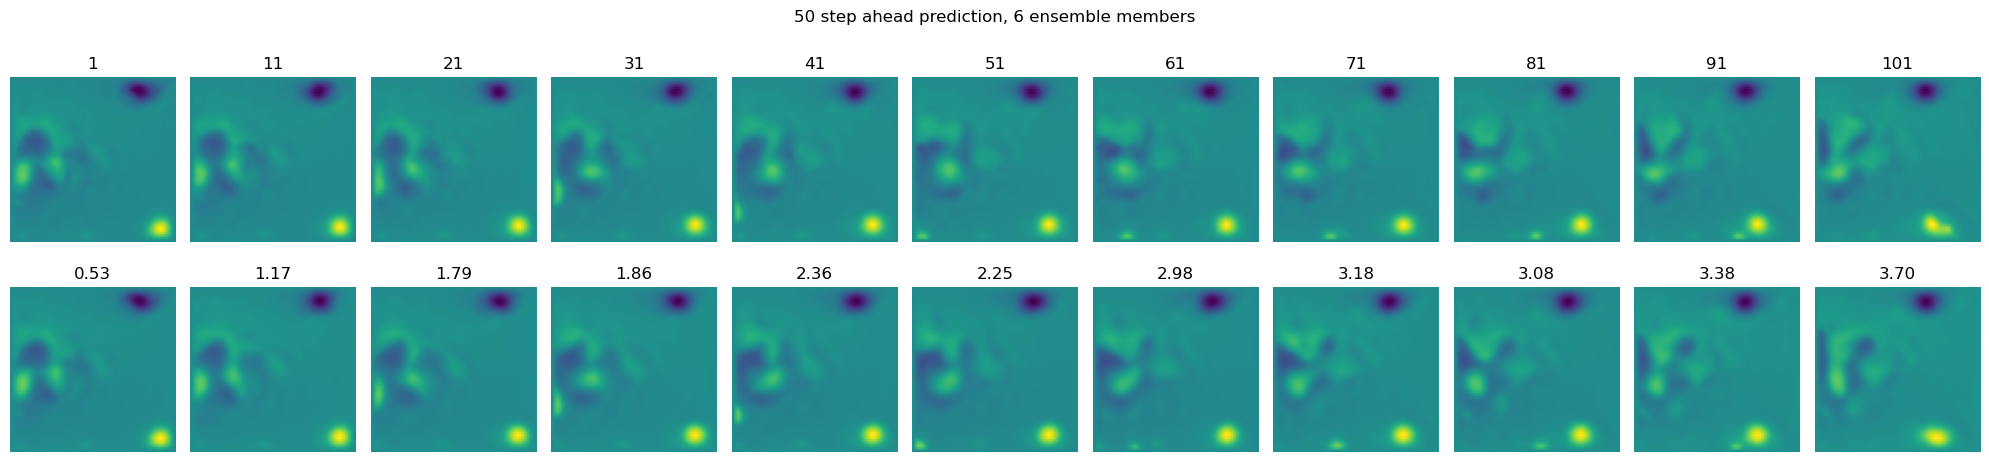

In [105]:
n_ens = 6

ensembles = []
ensembles_latent = []
with torch.no_grad():
    for i in range(n_ens):    
        #latents = torch.randn_like(class_labels, device=device)
        #latents = torch.randn_like(previous_latent, device=device).repeat(current.shape[0], 1, 1, 1)
        #latents = latents_list[i]

        #--
        latentsDriving = torch.randn_like(previous_latent, device=device).repeat(current.shape[0], 1, 1, 1)
        latentsNoising = torch.randn_like(latentsDriving, device=device)
        latents = np.sqrt(1-alpha) * latentsDriving + np.sqrt(alpha) * latentsNoising
        # --

        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/kmax, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        predicted_latent = previous_latent + predicted_residuals * scaling

        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data

        ensembles.append(predicted_unnormalized)
        ensembles_latent.append(predicted_latent)

ensembles = torch.stack(ensembles)
ensembles_latent = torch.stack(ensembles_latent)
ens_mean = ensembles.mean(dim=0)


def plot_image(ax, image, title=None):
    image = image.cpu().detach().numpy().reshape((65,65))
    ax.imshow(image)
    if title:
        ax.set_title(title)
    ax.axis('off')

plt.set_cmap('viridis')

num_figs = 11
fig, axes = plt.subplots(2,num_figs, figsize=(20,5))
fig.suptitle(f'{k} step ahead prediction, {n_ens} ensemble members')


#ks = np.arange(kmin, kmax+1, 20)

dk = 10
ks = np.arange(kmin, kmin+dk*num_figs, dk)

torch.arange(val_time_series_dataset.kmin, val_time_series_dataset.kmax+1, val_time_series_dataset.d,  device=device, dtype=int)


spreads = []
skills = []

for i in range(len(ks)):
    truth = current_unnormalized[(ks[i]-kmin)//d]
    predicted = ens_mean[(ks[i]-kmin)//d]
    predicted = ensembles[0, (ks[i]-kmin)//d]
    ensemble = ensembles[:, (ks[i]-kmin)//d]

    plot_image(axes[0,i], truth, f"{ks[i]}")
    plot_image(axes[1,i], predicted, f"{calculate_RMSE(truth.unsqueeze(0), predicted.unsqueeze(0)).item():.2f}")

    skill, spread,_ = calculate_skill_and_spread_score(ensemble, truth)
    spreads.append(spread[0])
    skills.append(skill[0])

plt.tight_layout()
plt.show()

In [86]:
ks = torch.arange(val_time_series_dataset.kmin, val_time_series_dataset.kmax+1, val_time_series_dataset.d,  device=device, dtype=int)

spreads = []
skills = []
rmses = []

for i, ki in enumerate(ks):
    truth = current_unnormalized[(ki-kmin)//d]
    rmse_k = []

    ensemble = ensembles[:, (ki-kmin)//d]

    rmses.append(calculate_RMSE(ensemble, truth).flatten())

rmses = np.array(rmses)

In [107]:
truth = current_unnormalized[:, 0, :, :].cpu().detach().numpy()
decoded_truth = decoded_current_unnormalized[:, 0, :, :].cpu().detach().numpy()
forecasts = ensembles[:, :, 0, :, :].cpu().detach().numpy()
mean_forecast = forecasts.mean(axis=0)
stds = forecasts.std(axis=0)

In [237]:
truth_latent = current_latent[:, 0, :, :].cpu().detach().numpy()
forecast_latent = ensembles_latent[:,:, 0, :, :].cpu().detach().numpy()
mean_latent = forecast_latent.mean(axis=0)
stds_latent = forecast_latent.std(axis=0)

truth = truth_latent
forecasts = forecast_latent
mean_forecast = mean_latent
stds = stds_latent

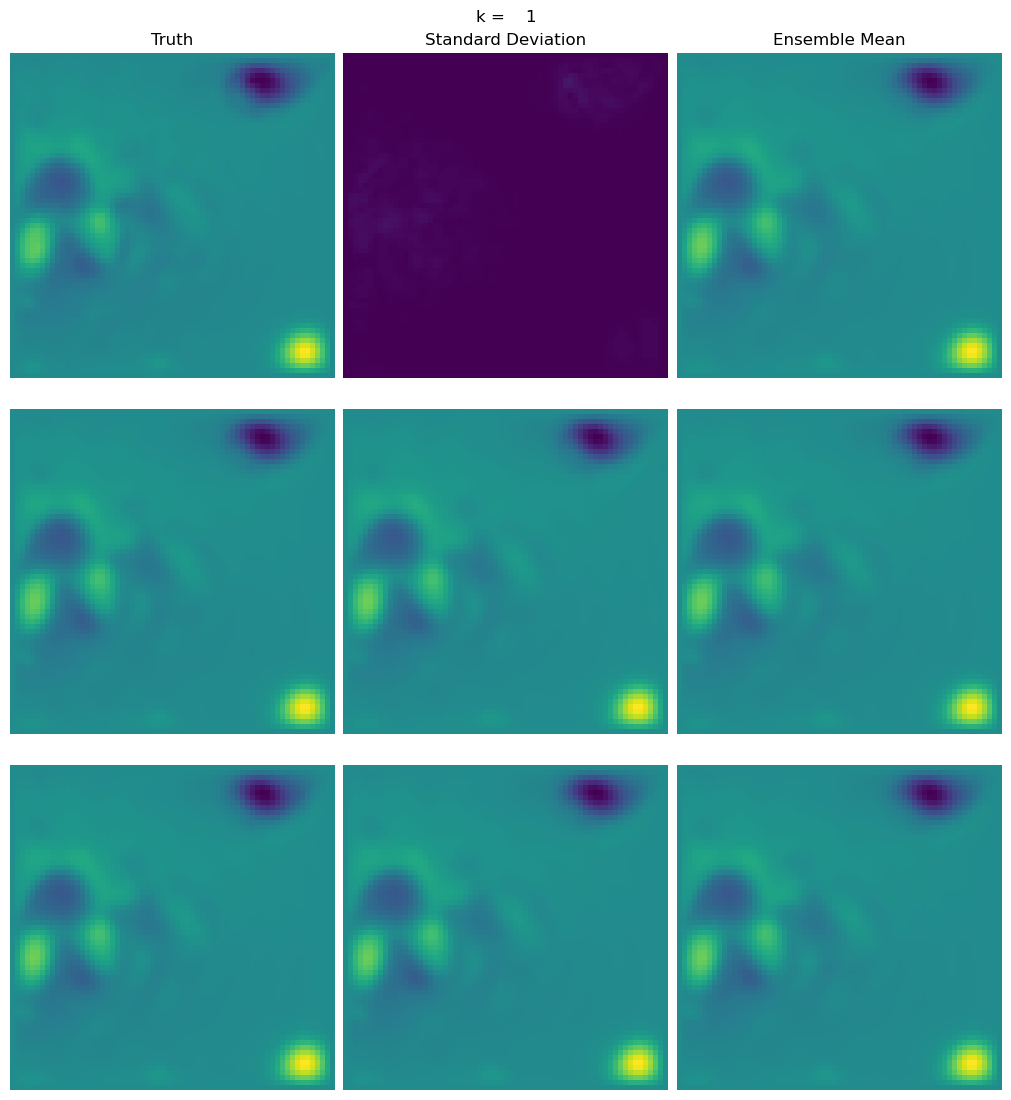

In [109]:
%matplotlib inline

from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')


fig, axes = plt.subplots(3,3, figsize=(10,11), constrained_layout=True)
#fig, axes = plt.subplots(2,3, figsize=(10,7), constrained_layout=True)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    ax.axis('off')

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')
title3 = axes[0,2].set_title('')

images = []
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        images.append(ax.imshow(truth[0]))
    elif i == 1:
        images.append(ax.imshow(stds[0], vmin=0, vmax = stds.max()))
        #images.append(ax.imshow(decoded_truth[0]))

    elif i == 2:
        images.append(ax.imshow(mean_forecast[0]))
    else:
        images.append(ax.imshow(forecasts[i-3,0]))

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i == 0:
            im.set_array(truth[n])
        elif i == 1:
            im.set_array(stds[n])
            #im.set_array(decoded_truth[n])
        elif i == 2:
            im.set_array(mean_forecast[n])
        else:
            im.set_array(forecasts[i-3,n])

    txt_title.set_text('k = {0:4d}'.format(d*n+kmin))
    title1.set_text('Truth')
    #title2.set_text('Decoded Truth')
    title2.set_text('Standard Deviation')
    title3.set_text('Ensemble Mean')

    return images

#plt.tight_layout(rect=[0, 0, 1, 0.95])

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=150, interval=100)

#anim.save('animation.gif', writer='imagemagick', fps=30)
HTML(anim.to_html5_video())

In [110]:
anim.save('animation.gif', writer='imagemagick', fps=30)

### Continuous wrt IC?

In [175]:
model.eval()  # Set model to evaluation mode


current_list = []
previous_latent_list = []
class_labels_list = []

n_batches = 2

with torch.no_grad():
    for previous, current in (val_time_series_loader):
        if n_batches == 0:
            break
        current = current.to(device).permute(1,0,2,3)
        previous = previous.to(device)

        current_latent = autoencoder.encoder(current)

        time_labels = torch.arange(val_time_series_dataset.kmin, val_time_series_dataset.kmax+1, val_time_series_dataset.d,  device=device, dtype=int)
        
        previous_latent = autoencoder.encoder(previous)
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        
        class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

        current_unnormalized = current * std_data + mean_data

        current_list.append(current_unnormalized)
        previous_latent_list.append(previous_latent)
        class_labels_list.append(class_labels)

        n_batches -= 1

In [179]:
choice = 1
class_labels = class_labels_list[choice]
previous_latent = previous_latent_list[choice]
current = current_list[choice]

In [177]:
n_ens = 3

latents_list = []
ensembles_list = []

for i in range(n_ens): 
    latents = torch.randn_like(previous_latent, device=device).repeat(current.shape[0], 1, 1, 1)
    latents_list.append(latents)

<Figure size 640x480 with 0 Axes>

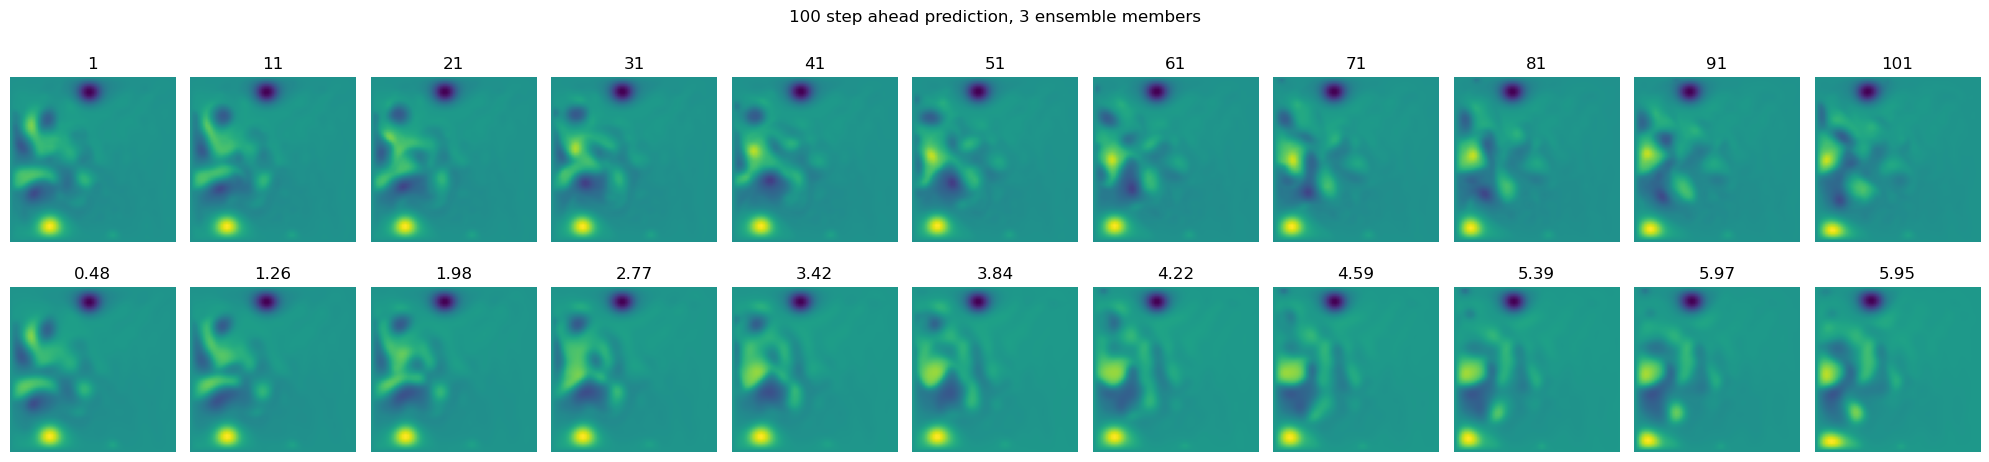

In [180]:
ensembles = []
ensembles_latent = []

with torch.no_grad():
    for i in range(n_ens):    
        #latents = torch.randn_like(previous_latent, device=device).repeat(current.shape[0], 1, 1, 1)
        latents = latents_list[i]
        
        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/kmax, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        predicted_latent = previous_latent + predicted_residuals * scaling

        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data

        ensembles.append(predicted_unnormalized)
        ensembles_latent.append(predicted_latent)

ensembles = torch.stack(ensembles)
ensembles_latent = torch.stack(ensembles_latent)
ens_mean = ensembles.mean(dim=0)


def plot_image(ax, image, title=None):
    image = image.cpu().detach().numpy().reshape((65,65))
    ax.imshow(image)
    if title:
        ax.set_title(title)
    ax.axis('off')

plt.set_cmap('viridis')

num_figs = 11
fig, axes = plt.subplots(2,num_figs, figsize=(20,5))
fig.suptitle(f'{k} step ahead prediction, {n_ens} ensemble members')


#ks = np.arange(kmin, kmax+1, 20)

dk = 10
ks = np.arange(kmin, kmin+dk*num_figs, dk)

torch.arange(val_time_series_dataset.kmin, val_time_series_dataset.kmax+1, val_time_series_dataset.d,  device=device, dtype=int)


spreads = []
skills = []

for i in range(len(ks)):
    truth = current_unnormalized[(ks[i]-kmin)//d]
    predicted = ens_mean[(ks[i]-kmin)//d]
    predicted = ensembles[0, (ks[i]-kmin)//d]
    ensemble = ensembles[:, (ks[i]-kmin)//d]

    plot_image(axes[0,i], truth, f"{ks[i]}")
    plot_image(axes[1,i], predicted, f"{calculate_RMSE(truth.unsqueeze(0), predicted.unsqueeze(0)).item():.2f}")

    skill, spread,_ = calculate_skill_and_spread_score(ensemble, truth)
    spreads.append(spread[0])
    skills.append(skill[0])

plt.tight_layout()
plt.show()

ensembles_list.append(ensembles)

In [181]:
current_list = torch.stack(current_list)
ensembles_list = torch.stack(ensembles_list)

In [192]:
# Remove the correct time step

dk = 50
ensembles = ensembles_list[0,:,dk:] - ensembles_list[1,:,:-dk]
current_unnormalized = current_list[0,dk:] #- current_list[1,:-dk]


In [186]:
# Remove the permuted time step
rolled_ensembles = torch.roll(ensembles_list, shifts=-1, dims=1)
ensembles = rolled_ensembles[0,:,dk:] - ensembles_list[1,:,:-dk]


In [193]:
truth = current_unnormalized[:, 0, :, :].cpu().detach().numpy()
forecasts = ensembles[:, :, 0, :, :].cpu().detach().numpy()
mean_forecast = forecasts.mean(axis=0)
stds = forecasts.std(axis=0)

In [ ]:
truth_latent = current_latent[:, 0, :, :].cpu().detach().numpy()
forecast_latent = ensembles_latent[:,:, 0, :, :].cpu().detach().numpy()
mean_latent = forecast_latent.mean(axis=0)
stds_latent = forecast_latent.std(axis=0)

truth = truth_latent
forecasts = forecast_latent
mean_forecast = mean_latent
stds = stds_latent

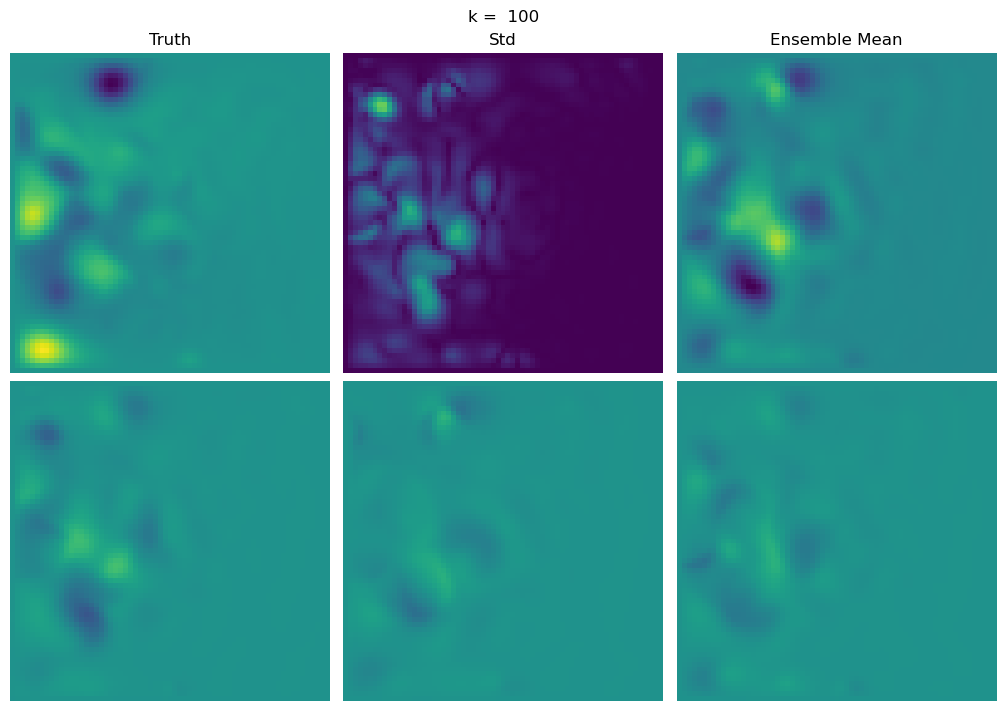

In [194]:
%matplotlib inline

from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')


#fig, axes = plt.subplots(3,3, figsize=(10,11), constrained_layout=True)
fig, axes = plt.subplots(2,3, figsize=(10,7), constrained_layout=True)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    ax.axis('off')

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')
title3 = axes[0,2].set_title('')

images = []
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        images.append(ax.imshow(truth[0]))
    elif i == 1:
        images.append(ax.imshow(stds[0], vmin=0, vmax = stds.max()))
        #images.append(ax.imshow(decoded_truth[0]))

    elif i == 2:
        images.append(ax.imshow(mean_forecast[0]))
    else:
        images.append(ax.imshow(forecasts[i-3,0], vmin=truth.min(), vmax = truth.max()))

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i == 0:
            im.set_array(truth[n])
        elif i == 1:
            im.set_array(stds[n])
            #im.set_array(decoded_truth[n])
        elif i == 2:
            im.set_array(mean_forecast[n])
        else:
            im.set_array(forecasts[i-3,n])

    txt_title.set_text('k = {0:4d}'.format(n+kmin))
    title1.set_text('Truth')
    #title2.set_text('Decoded Truth')
    title2.set_text('Std')
    title3.set_text('Ensemble Mean')

    return images

#plt.tight_layout(rect=[0, 0, 1, 0.95])

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=150-dk, interval=50, blit=True)

#anim.save('animation.gif', writer='imagemagick', fps=30)
HTML(anim.to_html5_video())

In [ ]:
anim.save('animation.gif', writer='imagemagick', fps=30)

### Linear Interpolation

In [195]:
model.eval()  # Set model to evaluation mode


with torch.no_grad():
    for previous, current in (val_time_series_loader):
        current = current.to(device).permute(1,0,2,3)
        previous = previous.to(device)

        current_latent = autoencoder.encoder(current)

        time_labels = torch.arange(val_time_series_dataset.kmin, val_time_series_dataset.kmax+1, val_time_series_dataset.d,  device=device, dtype=int)
        
        previous_latent = autoencoder.encoder(previous)
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        
        class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

        current_unnormalized = current * std_data + mean_data
        previous_unnormalized = previous * std_data + mean_data
        decoded_current_unnormalized = autoencoder.decoder(current_latent) * std_data + mean_data

        break

In [208]:
latents1 = torch.randn_like(previous_latent, device=device).repeat(current.shape[0], 1, 1, 1)
latents2 = torch.randn_like(previous_latent, device=device).repeat(current.shape[0], 1, 1, 1)

num_alphas = 11
alphas = np.linspace(0, 1, num_alphas)

def interpolate_latents(alpha):
    return np.sqrt(1-alpha)*latents1 + np.sqrt(alpha)*latents2

latents_list = []

for alpha in alphas:
    latents_list.append(interpolate_latents(alpha))


latents_list = torch.stack(latents_list)

In [209]:
latents_list.shape

torch.Size([11, 150, 1, 16, 16])

<Figure size 640x480 with 0 Axes>

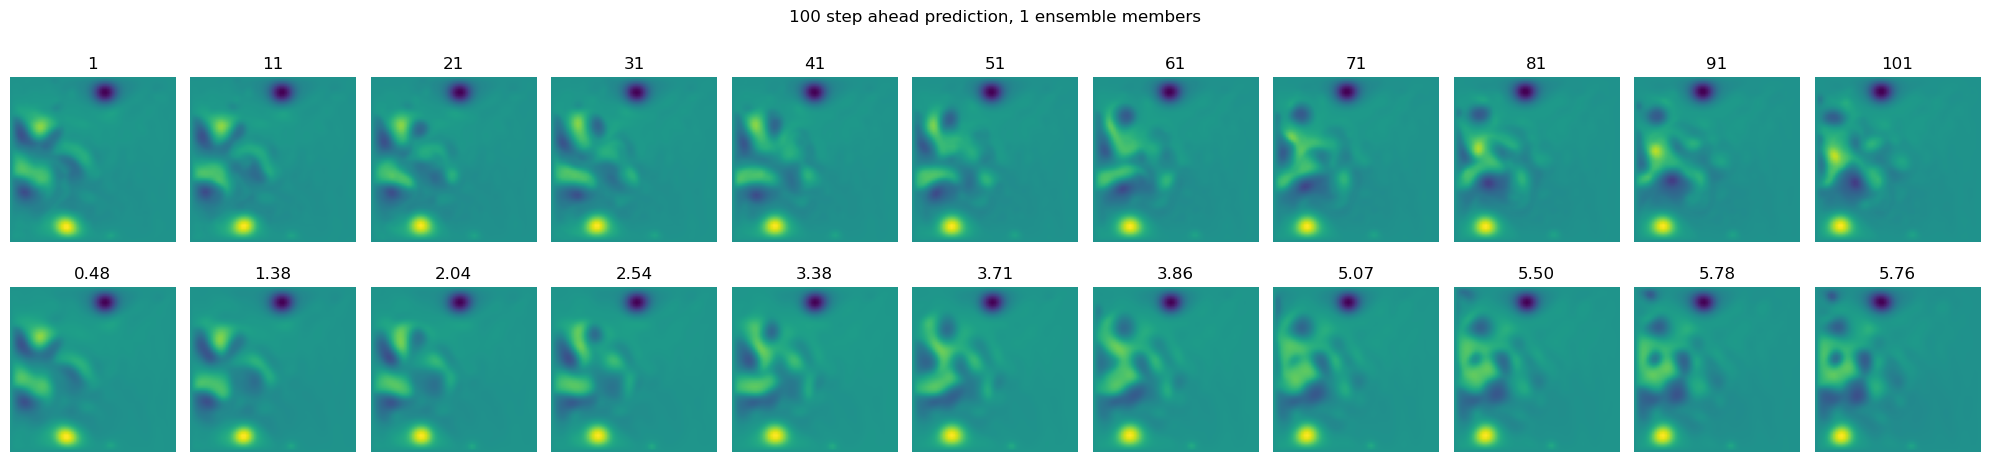

In [210]:
n_ens = 1


ensembles = []
ensembles_latent = []
with torch.no_grad():
    for i in range(num_alphas):    
        #latents = torch.randn_like(previous_latent, device=device).repeat(current.shape[0], 1, 1, 1)
        latents = latents_list[i]
        
        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/kmax, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        predicted_latent = previous_latent + predicted_residuals * scaling

        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data

        ensembles.append(predicted_unnormalized)
        ensembles_latent.append(predicted_latent)

ensembles = torch.stack(ensembles)
ensembles_latent = torch.stack(ensembles_latent)
ens_mean = ensembles.mean(dim=0)


def plot_image(ax, image, title=None):
    image = image.cpu().detach().numpy().reshape((65,65))
    ax.imshow(image)
    if title:
        ax.set_title(title)
    ax.axis('off')

plt.set_cmap('viridis')

num_figs = 11
fig, axes = plt.subplots(2,num_figs, figsize=(20,5))
fig.suptitle(f'{k} step ahead prediction, {n_ens} ensemble members')


#ks = np.arange(kmin, kmax+1, 20)

dk = 10
ks = np.arange(kmin, kmin+dk*num_figs, dk)

torch.arange(val_time_series_dataset.kmin, val_time_series_dataset.kmax+1, val_time_series_dataset.d,  device=device, dtype=int)


spreads = []
skills = []

for i in range(len(ks)):
    truth = current_unnormalized[(ks[i]-kmin)//d]
    predicted = ens_mean[(ks[i]-kmin)//d]
    predicted = ensembles[0, (ks[i]-kmin)//d]
    ensemble = ensembles[:, (ks[i]-kmin)//d]

    plot_image(axes[0,i], truth, f"{ks[i]}")
    plot_image(axes[1,i], predicted, f"{calculate_RMSE(truth.unsqueeze(0), predicted.unsqueeze(0)).item():.2f}")

    skill, spread,_ = calculate_skill_and_spread_score(ensemble, truth)
    spreads.append(spread[0])
    skills.append(skill[0])

plt.tight_layout()
plt.show()

In [211]:
truth = current_unnormalized[:, 0, :, :].cpu().detach().numpy()
decoded_truth = decoded_current_unnormalized[:, 0, :, :].cpu().detach().numpy()
forecasts = ensembles[:, :, 0, :, :].cpu().detach().numpy()
mean_forecast = forecasts.mean(axis=0)
stds = forecasts.std(axis=0)

In [ ]:
truth_latent = current_latent[:, 0, :, :].cpu().detach().numpy()
forecast_latent = ensembles_latent[:,:, 0, :, :].cpu().detach().numpy()
mean_latent = forecast_latent.mean(axis=0)
stds_latent = forecast_latent.std(axis=0)

truth = truth_latent
forecasts = forecast_latent
mean_forecast = mean_latent
stds = stds_latent

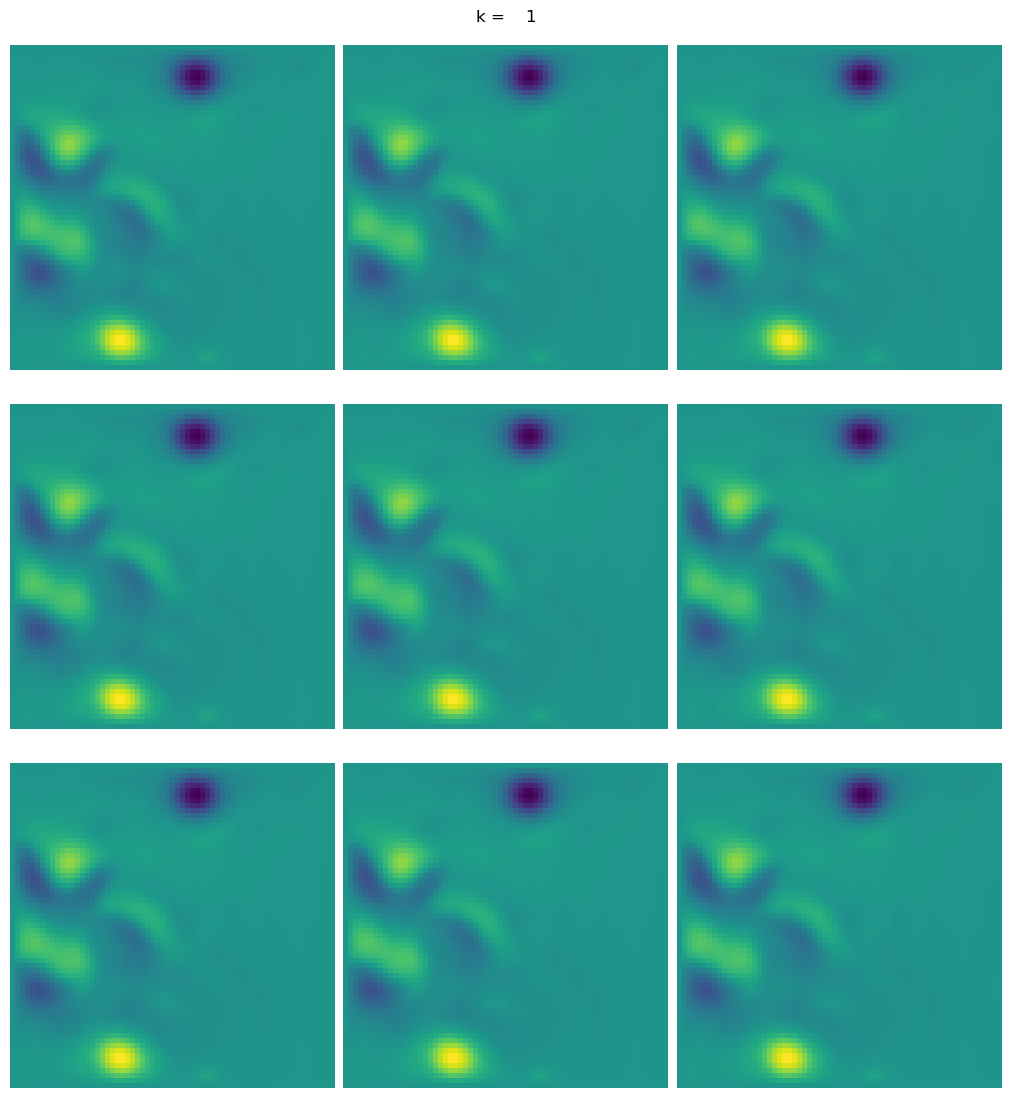

In [215]:
%matplotlib inline

from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')


fig, axes = plt.subplots(3,3, figsize=(10,11), constrained_layout=True)
#fig, axes = plt.subplots(2,3, figsize=(10,7), constrained_layout=True)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    ax.axis('off')

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')
title3 = axes[0,2].set_title('')

images = []
for i, ax in enumerate(axes.flatten()):
    images.append(ax.imshow(forecasts[i,0]))

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        im.set_array(forecasts[i,n])

    txt_title.set_text('k = {0:4d}'.format(n+kmin))

    return images

#plt.tight_layout(rect=[0, 0, 1, 0.95])

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=150, interval=50)

#anim.save('animation.gif', writer='imagemagick', fps=30)
HTML(anim.to_html5_video())

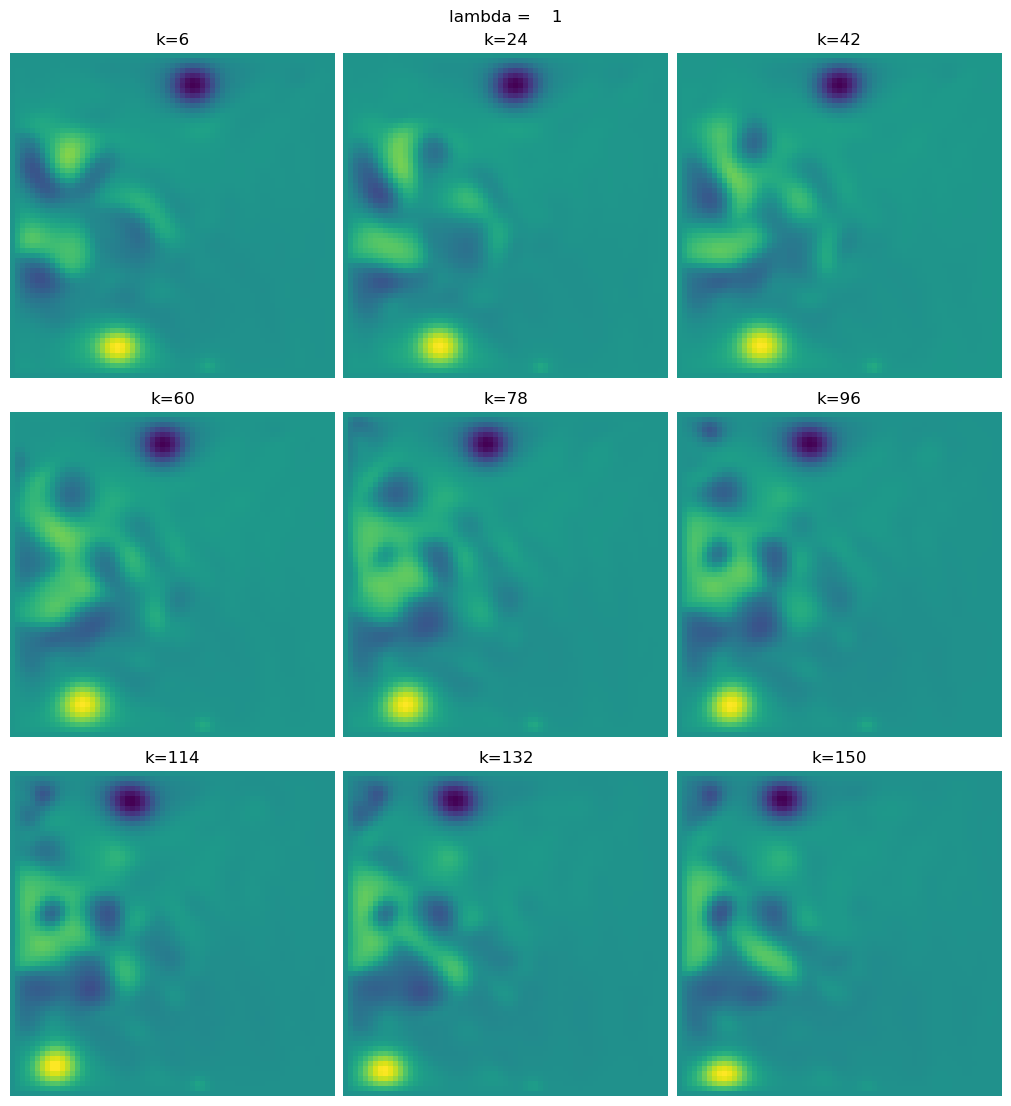

In [241]:
%matplotlib inline

from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')


fig, axes = plt.subplots(3,3, figsize=(10,11), constrained_layout=True)
#fig, axes = plt.subplots(2,3, figsize=(10,7), constrained_layout=True)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    ax.axis('off')

images = []
ks = np.linspace(kmin+5, kmax, 9)

for i, ax in enumerate(axes.flatten()):
    images.append(ax.imshow(forecasts[0,int(ks[i])-1]))
    ax.set_title(f'k={int(ks[i])}')

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        im.set_array(forecasts[n, int(ks[i])-1])

    txt_title.set_text('lambda = {0:4d}'.format(n+kmin))

    return images

#plt.tight_layout(rect=[0, 0, 1, 0.95])

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=11, interval=100)

#anim.save('animation.gif', writer='imagemagick', fps=30)
HTML(anim.to_html5_video())

In [238]:
np.linspace(kmin+5, kmax, 9)

array([  6.,  24.,  42.,  60.,  78.,  96., 114., 132., 150.])

In [243]:
anim.save('animation.gif', writer='imagemagick', fps=11)

### Single point evaluation

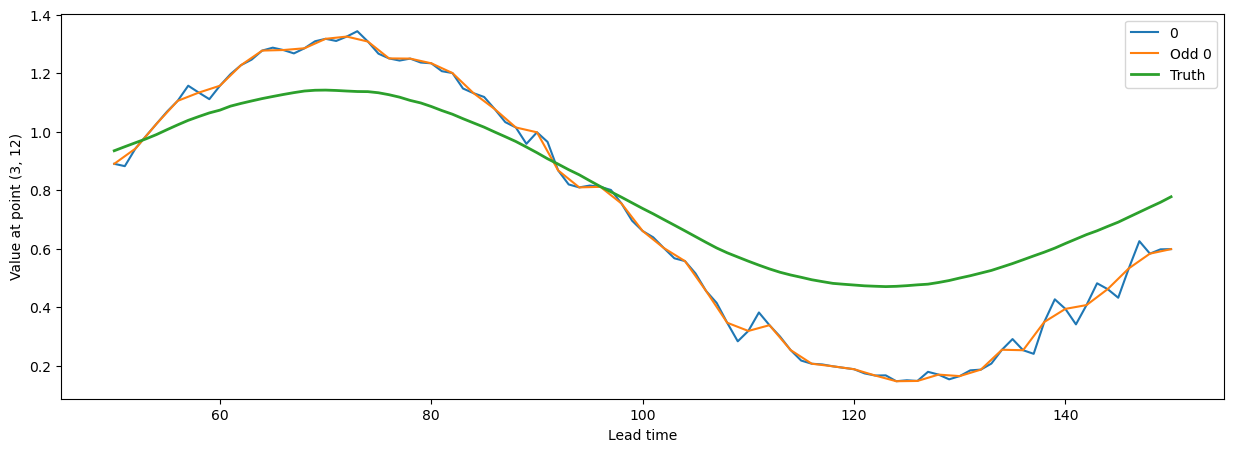

In [252]:
px_x, px_y = np.random.randint(0,16, 2)

fig = plt.figure(figsize=(15,5))
rens = np.random.randint(0,10)

ks = np.arange(50,151)
for i in range(n_ens):
    px_forecast = forecasts[i,:, px_x, px_y]
    plt.plot(ks, px_forecast, label=f'{i}')#, marker = '.', linewidth=0, markersize=5)
    px_forecast = forecasts[i,::2, px_x, px_y]
    plt.plot(ks[::2], px_forecast, label=f'Odd {i}')#, marker = '.', linewidth=0, markersize=5)
    
    break

px_mean = mean_forecast[:, px_x, px_y]
px_truth = truth[:, px_x, px_y]
px_decoded_truth = decoded_truth[:, px_x, px_y]

#plt.plot(px_mean, label='Mean', linewidth=2)
plt.plot(ks, px_truth, label='Truth', linewidth=2)
#plt.plot(ks,px_decoded_truth, label='Decoded Truth', linewidth=2)

plt.xlabel('Lead time')
plt.ylabel(f'Value at point {px_x, px_y}')

plt.legend()



### KNN

In [28]:
# KNN

# Fixed k sampling
training_size =200000 #1679900
batch_size = 256
n_ens = 10

train_dataset = QGSamplesDataset(data_path, 'train', p_train, k, spinup, spacing, iterations, mean_data, std_data, 'cpu')
val_dataset = QGSamplesDataset(data_path, 'val', p_train, k, spinup, spacing, iterations, mean_data, std_data, 'cpu')

train_loader = DataLoader(train_dataset, batch_size=training_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

shuffled_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

from sklearn.neighbors import KNeighborsRegressor

for previous_train, current_train in train_loader:
    previous_train = previous_train.view(previous_train.shape[0],-1) * std_data + mean_data
    current_train = current_train.view(previous_train.shape[0],-1) * std_data + mean_data
    break

knn = KNeighborsRegressor(n_neighbors=n_ens, weights='distance')
knn.fit(previous_train, current_train)


KNeighborsRegressor(n_neighbors=10, weights='distance')

In [30]:
batch_size = 100

val_dataset = QGSamplesDataset(data_path, 'val', p_train, k, spinup, spacing, iterations, mean_data, std_data, 'cpu')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

for previous_val_unnorm, current_val in val_loader:
    previous_val = previous_val_unnorm.view(previous_val_unnorm.shape[0],-1) * std_data + mean_data
    current_val = current_val.view(previous_val.shape[0],-1) * std_data + mean_data
    break

Y_pred = knn.predict(previous_val).astype('float32')

neigh_dist, neigh_ind = knn.kneighbors(previous_val)
ens_pred = current_train[neigh_ind]

ens_pred = ens_pred.permute(1,0,2).reshape(ens_pred.shape[1],ens_pred.shape[0], 1, 65,65)
current_val = current_val.view(batch_size, 1, 65, 65)

In [31]:
n_ens = 10
predicted_unnormalized = generate_ensemble_from_batch(model, previous_val_unnorm.to(device), n_ens=n_ens, sampler_fn=edm_sampler)

In [32]:
batch_size = 100
n_batches = 10

val_dataset = QGSamplesDataset(data_path, 'val', p_train, k, spinup, spacing, iterations, mean_data, std_data, 'cpu')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model_skill, model_spread = [], []

with torch.no_grad():
    for count, (previous, current) in enumerate(tqdm(val_loader, total=n_batches)):
        if count >= n_batches:
            break
        
        previous = previous.to(device)
        current = current.to(device)
        
        predicted_unnormalized = generate_ensemble_from_batch(model, previous.to(device), n_ens=n_ens, sampler_fn=edm_sampler)

        current_unnormalized = current * std_data + mean_data
        previous_unnormalized = previous * std_data + mean_data

        ensemble_mean = predicted_unnormalized.mean(dim=0)

        model_skills, model_spreads, _ = calculate_skill_and_spread_score(predicted_unnormalized, current_unnormalized)

        model_skill.append(model_skills)
        model_spread.append(model_spreads)

model_skill = np.concatenate(model_skill)
model_spread = np.concatenate(model_spread)

100%|██████████| 10/10 [03:15<00:00, 19.50s/it]


In [33]:
truth = current_val

forecast_knn = ens_pred
forecast_model = predicted_unnormalized.to('cpu')

knn_skill, knn_spread, _ = calculate_skill_and_spread_score(forecast_knn, truth)
#model_skill, model_spread, _ = calculate_skill_and_spread_score(forecast_model, truth)

print(f'KNN Skill: {knn_skill[0].item():.2f}, Spread: {knn_spread[0].item():.2f}')
print(f'Model Skill: {model_skill[0].item():.2f}, Spread: {model_spread[0].item():.2f}')

KNN Skill: 7.31, Spread: 7.35
Model Skill: 4.08, Spread: 4.10


In [ ]:

running_mean=100
key = 'spread'

#x = np.arange(0, len(nwp_skill))

fig, axes = plt.subplots(1,1, figsize=(12,5))

ax1 = axes
ax2 = ax1.twinx()
ax1.set_title(f'Model {key} vs RMSE NWP')

ax1.plot(uniform_filter1d(knn_spread, size=running_mean), color='blue', label='KNN Spread')
ax1.set_xlabel('Time')
ax1.set_ylabel('RMSE NWP')

ax2.set_ylabel(f'Model {key}')
ax2.plot(uniform_filter1d(model_spread, size=running_mean), color='red', label=f'Model Spread')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()



In [ ]:
knn_std = forecast_knn.std(dim=0)
model_std = forecast_model.std(dim=0)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))

idx = np.random.randint(0, batch_size)
kdx = np.random.randint(0, 10)
rdx = np.random.randint(0, 10)

forecast_kn = forecast_knn[kdx,idx].reshape(65, 65)
forecast_pred = Y_pred[idx].reshape(65, 65)
forecast_diff = forecast_model[rdx, idx, 0].to('cpu')
truth = current_val[idx,0].reshape(65, 65)
knn_std_img = knn_std[idx].reshape(65, 65)
model_std_img = model_std[idx].reshape(65, 65)

axes[0,0].imshow(forecast_kn)
axes[0,0].set_title('KNN Prediction')
axes[0,0].axis('off')

axes[0,1].imshow(truth)
axes[0,1].set_title('Truth')
axes[0,1].axis('off')

axes[0,2].imshow(forecast_diff)
axes[0,2].set_title('Model Prediction')
axes[0,2].axis('off')

axes[1,0].imshow(knn_std_img)
axes[1,0].set_title('KNN Std')
axes[1,0].axis('off')

axes[1,1].imshow(model_std_img)
axes[1,1].set_title('Model Std')
axes[1,1].axis('off')

axes[1,2].imshow(forecast_pred)
axes[1,2].set_title('KNN Avg Prediction')
axes[1,2].axis('off')

### MISC

In [ ]:
predicted_unnormalized, current_unnormalized, previous_unnormalized = generate_ensemble_from_single_random(model, n_ens=1000, selected_loader = shuffled_val_loader, sampler_fn=edm_sampler)

rmse_ensemble = calculate_RMSE(predicted_unnormalized, current_unnormalized).flatten()
mae_ensemble = calculate_MAE(predicted_unnormalized, current_unnormalized).flatten()

ensemble_mean = predicted_unnormalized.mean(dim=0)

rmse_to_mean = calculate_RMSE(predicted_unnormalized, ensemble_mean).flatten()
mae_to_mean = calculate_MAE(predicted_unnormalized, ensemble_mean).flatten()

ensemble_skill = calculate_RMSE(ensemble_mean, current_unnormalized).item()
ensemble_mean_mae = calculate_MAE(ensemble_mean, current_unnormalized).item()


In [ ]:
from scipy import stats

stats.mode(rmse_ensemble)

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(10, 10))
bins= 30
axes[0,0].hist2d(rmse_to_mean, rmse_ensemble, bins=bins, cmap='Blues')
axes[0,0].set_xlabel('RMSE to Mean')
axes[0,0].set_ylabel('RMSE of Members')
axes[0,0].set_title('RMSE to Mean vs RMSE of Members')
axes[0,0].hlines(ensemble_skill, min(rmse_to_mean), max(rmse_to_mean), color='red', linestyle='--')
axes[0,0].hlines(np.mean(rmse_ensemble), min(rmse_to_mean), max(rmse_to_mean), color='green', linestyle='--')

axes[0,1].hist2d(mae_to_mean, rmse_ensemble, bins=bins, cmap='Blues')
axes[0,1].set_xlabel('MAE to Mean')
axes[0,1].set_ylabel('RMSE of Members')
axes[0,1].set_title('MAE to Mean vs RMSE of Members')
axes[0,1].hlines(ensemble_skill, min(mae_to_mean), max(mae_to_mean), color='red', linestyle='--')
axes[0,1].hlines(np.mean(rmse_ensemble), min(mae_to_mean), max(mae_to_mean), color='green', linestyle='--')

axes[1,0].hist2d(rmse_to_mean, mae_ensemble, bins=bins, cmap='Blues')
axes[1,0].set_xlabel('RMSE to Mean')
axes[1,0].set_ylabel('MAE of Members')
axes[1,0].set_title('RMSE to Mean vs MAE of Members')
axes[1,0].hlines(ensemble_mean_mae, min(rmse_to_mean), max(rmse_to_mean), color='red', linestyle='--')
axes[1,0].hlines(np.mean(mae_ensemble), min(rmse_to_mean), max(rmse_to_mean), color='green', linestyle='--')

axes[1,1].hist2d(mae_to_mean, mae_ensemble, bins=bins, cmap='Blues')
axes[1,1].set_xlabel('MAE to Mean')
axes[1,1].set_ylabel('MAE of Members')
axes[1,1].set_title('MAE to Mean vs MAE of Members')
axes[1,1].hlines(ensemble_mean_mae, min(mae_to_mean), max(mae_to_mean), color='red', linestyle='--')
axes[1,1].hlines(np.mean(mae_ensemble), min(mae_to_mean), max(mae_to_mean), color='green', linestyle='--')

plt.tight_layout()
plt.show()

In [ ]:

fig, axes = plt.subplots(2,2, figsize=(10, 10))

axes[0,0].scatter(rmse_to_mean, rmse_ensemble, alpha=0.5)
axes[0,0].set_xlabel('RMSE to Mean')
axes[0,0].set_ylabel('RMSE of Members')
axes[0,0].set_title('RMSE to Mean vs RMSE of Members')
axes[0,0].hlines(ensemble_skill, min(rmse_to_mean), max(rmse_to_mean), color='red', linestyle='--')
axes[0,0].hlines(np.mean(rmse_ensemble), min(rmse_to_mean), max(rmse_to_mean), color='green', linestyle='--')

axes[0,1].scatter(mae_to_mean, rmse_ensemble, alpha=0.5)#, s=10, marker='o')
axes[0,1].set_xlabel('MAE to Mean')
axes[0,1].set_ylabel('RMSE of Members')
axes[0,1].set_title('MAE to Mean vs RMSE of Members')
axes[0,1].hlines(ensemble_skill, min(mae_to_mean), max(mae_to_mean), color='red', linestyle='--')
axes[0,1].hlines(np.mean(rmse_ensemble), min(mae_to_mean), max(mae_to_mean), color='green', linestyle='--')


axes[1,0].scatter(rmse_to_mean, mae_ensemble, alpha=0.5)
axes[1,0].set_xlabel('RMSE to Mean')
axes[1,0].set_ylabel('MAE of Members')
axes[1,0].set_title('RMSE to Mean vs MAE of Members')
axes[1,0].hlines(ensemble_mean_mae, min(rmse_to_mean), max(rmse_to_mean), color='red', linestyle='--')
axes[1,0].hlines(np.mean(mae_ensemble), min(rmse_to_mean), max(rmse_to_mean), color='green', linestyle='--')


axes[1,1].scatter(mae_to_mean, mae_ensemble, alpha=0.5)
axes[1,1].set_xlabel('MAE to Mean')
axes[1,1].set_ylabel('MAE of Members')
axes[1,1].set_title('MAE to Mean vs MAE of Members')
axes[1,1].hlines(ensemble_mean_mae, min(mae_to_mean), max(mae_to_mean), color='red', linestyle='--')
axes[1,1].hlines(np.mean(mae_ensemble), min(mae_to_mean), max(mae_to_mean), color='green', linestyle='--')

plt.tight_layout()
plt.show()

In [ ]:
predicted_unnormalized, current_unnormalized, previous_unnormalized = generate_ensemble_from_single_random(model, n_ens=500, selected_loader = shuffled_val_loader, sampler_fn=edm_sampler)

rmse_ensemble = calculate_RMSE(predicted_unnormalized, current_unnormalized).flatten()
mae_ensemble = calculate_MAE(predicted_unnormalized, current_unnormalized).flatten()

ensemble_mean = predicted_unnormalized.mean(dim=0)

rmse_to_mean = calculate_RMSE(predicted_unnormalized, ensemble_mean).flatten()
mae_to_mean = calculate_MAE(predicted_unnormalized, ensemble_mean).flatten()

ensemble_skill = calculate_RMSE(ensemble_mean, current_unnormalized).item()
ensemble_mean_mae = calculate_MAE(ensemble_mean, current_unnormalized).item()


rand_idx = np.random.randint(0, n_ens)
rand_idx = np.argmin(mae_to_mean)

best_idx = np.argmin(mae_ensemble)
fig, axes = plt.subplots(1, 5, figsize=(15, 10))

axes[0].imshow(current_unnormalized[0,0].cpu().detach().numpy())
axes[0].set_title('Truth')
axes[0].axis('off')
axes[1].imshow(predicted_unnormalized[rand_idx,0,0].cpu().detach().numpy())
axes[1].set_title('Closest to mean')
axes[1].axis('off')
axes[2].imshow(predicted_unnormalized.mean(dim=0)[0,0].cpu().detach().numpy())
axes[2].set_title('Ensemble Mean')
axes[2].axis('off')
axes[4].imshow(predicted_unnormalized.std(dim=0)[0,0].cpu().detach().numpy())
axes[4].set_title('Ensemble Std')
axes[4].axis('off')

axes[3].imshow(predicted_unnormalized[best_idx, 0,0].cpu().detach().numpy())
axes[3].set_title('Best RMSE')
axes[3].axis('off')



plt.tight_layout()


### Evaluation Pipeline

In [51]:
def calculate_psnr(pred, truth):
    mse = torch.mean((truth - pred)**2, axis = (2,3,4))
    max_truth, _ = (truth**2).view(truth.shape[0],-1).max(dim=1)
    psnr = torch.mean(10 * torch.log10(max_truth/mse), axis=0)
    return psnr.cpu().detach().numpy()

In [68]:
def evaluation_pipeline(model, n_ens=10, n_batches=1, selected_loader=val_loader, sampler_fn=edm_sampler):
    model.eval()

    results = {
                'skill': np.zeros(n_batches*batch_size),
                'spread': np.zeros(n_batches*batch_size),
                'ratio': np.zeros(n_batches*batch_size),
                'crps': np.zeros(n_batches*batch_size),
                'brier': np.zeros(n_batches*batch_size),
                'covtrace': np.zeros(n_batches*batch_size),
                'psnr': np.zeros(n_batches*batch_size),
                }
    
    results['rmse'] = np.zeros((n_ens, n_batches*batch_size))

    with torch.no_grad():
        for count, (previous, current) in (enumerate(tqdm(selected_loader, total=n_batches))):
            if count >= n_batches:
                break
            
            previous = previous.to(device)
            current = current.to(device)

            
            #predicted_unnormalized = generate_ensemble_from_batch(model, previous, n_ens=n_ens, sampler_fn=sampler_fn)
            predicted_unnormalized = generate_ar_ensemble_from_batch(model, previous, n_ens=n_ens, sampler_fn=sampler_fn, rollout=5, k=10)

            current_unnormalized = current * std_data + mean_data

            rmse = calculate_RMSE(predicted_unnormalized, current_unnormalized)

            skill, spread, ratio = calculate_skill_and_spread_score(predicted_unnormalized, current_unnormalized)
            crps = calculate_CRPS(predicted_unnormalized, current_unnormalized)
            brier = calculate_brier_score(predicted_unnormalized, current_unnormalized, 20)
            #covtrace = calculate_covtrace(predicted_unnormalized)    
            psnr = calculate_psnr(predicted_unnormalized, current_unnormalized)
            # Can make this easier by preallocating results
            results['skill'][count*batch_size:(count+1)*batch_size] = skill
            results['spread'][count*batch_size:(count+1)*batch_size] = spread
            results['ratio'][count*batch_size:(count+1)*batch_size] = ratio
            results['crps'][count*batch_size:(count+1)*batch_size] = crps
            results['brier'][count*batch_size:(count+1)*batch_size] = brier
            #results['covtrace'][count*batch_size:(count+1)*batch_size] = covtrace
            results['psnr'][count*batch_size:(count+1)*batch_size] = psnr

            results['rmse'][:,count*batch_size:(count+1)*batch_size] = rmse

    return results

#res = evaluation_pipeline(model, n_ens=1, n_batches=1, selected_loader=val_loader, sampler_fn=heun_sampler)

### Various Time Series Plots

In [70]:
n_batches = 1
n_ens = 10

k = 50
batch_size = 64

val_dataset = QGSamplesDataset(data_path, 'val', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

res = evaluation_pipeline(model, n_ens=n_ens, n_batches=n_batches, selected_loader=val_loader, sampler_fn=heun_sampler)

#skill, spread, ratio, crps, brier, rmse, covtrace = res['skill'], res['spread'], res['ratio'], res['crps'], res['brier'], res['rmse'], res['covtrace']


100%|██████████| 1/1 [01:08<00:00, 68.15s/it]


In [56]:
n_val = 210000
nwp_data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_LRES_{iterations}_n_{n_val}_k_{k}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_LRES_{iterations}_n_{n_val}_k_{k}.npy')

nwp_dataset = NWPDataset(nwp_data_path, n_val=n_val, spacing=spacing, device=device)
nwp_loader = DataLoader(nwp_dataset, batch_size=batch_size, shuffle=False)

nwp_skill = calculate_nwp_skill(n_batches=n_batches)
nwp_skill.mean()

0
1


9.511093

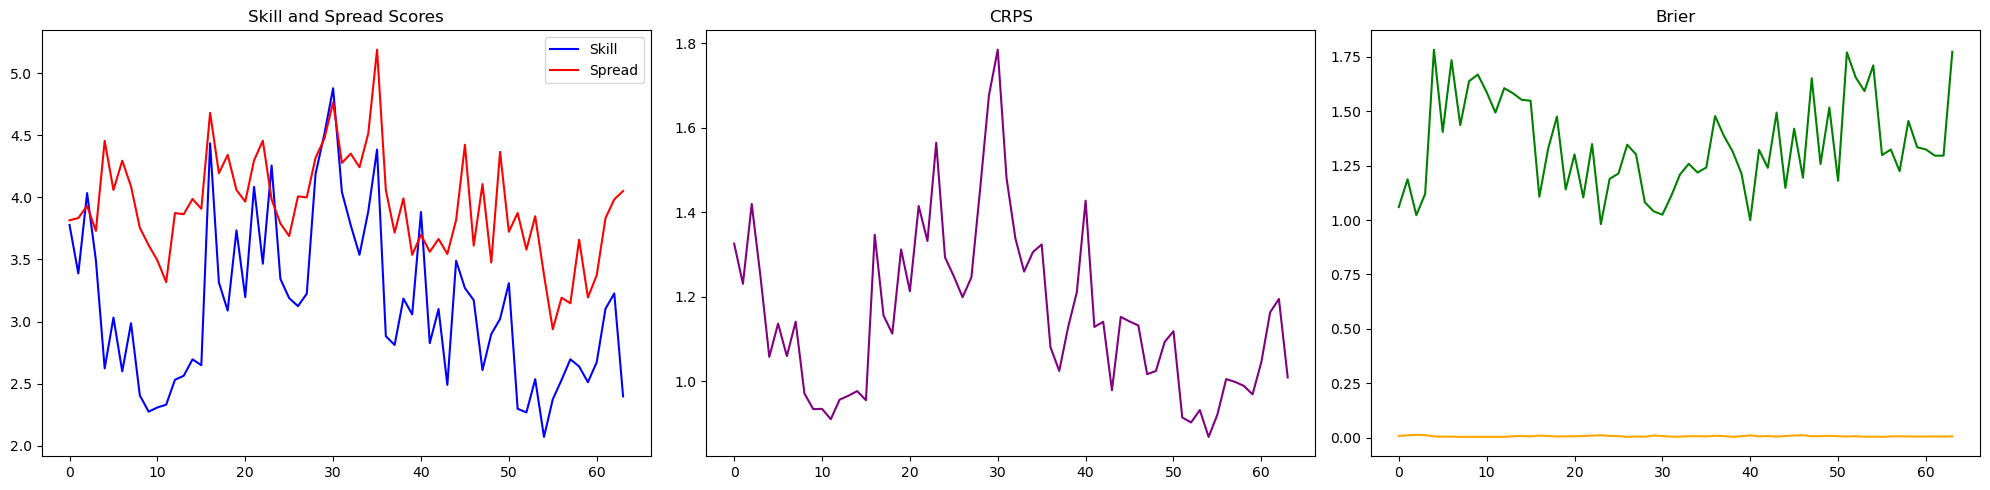

In [72]:
# Basic Plot
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].plot(res['skill'], label='Skill', color='blue')
axes[0].set_title('Skill and Spread Scores')
axes[0].plot(res['spread'], label='Spread', color='red')
axes[0].legend()

axes[2].plot(res['ratio'], label='Ratio', color='green')
axes[2].set_title('Ratio')

axes[1].plot(res['crps'], label='CRPS', color='purple')
axes[1].set_title('CRPS')

axes[2].plot(res['brier'], label='Brier', color='orange')
axes[2].set_title('Brier')

plt.tight_layout()

plt.show()

(array([  16.,   21.,   48.,  147., 1075., 2617.,  184.,   68.,   33.,
          16.]),
 array([-57.38971  , -46.137596 , -34.885483 , -23.63337  , -12.381256 ,
         -1.1291428,  10.122971 ,  21.375084 ,  32.627197 ,  43.87931  ,
         55.131424 ], dtype=float32),
 <BarContainer object of 10 artists>)

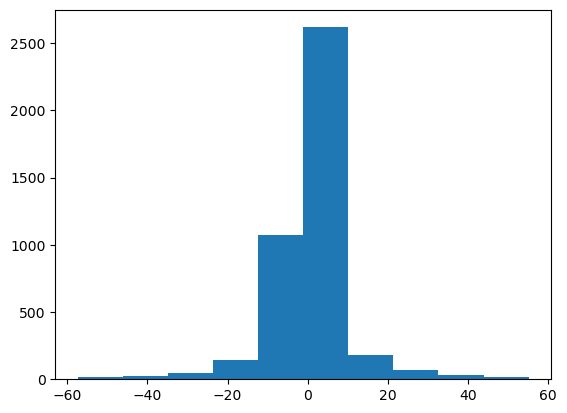

In [78]:
plt.hist(truth.flatten().cpu().detach().numpy())

In [71]:
print(res['skill'].mean())
print(res['spread'].mean())
print(res['ratio'].mean())
print(res['crps'].mean())
print(res['brier'].mean())

3.1352893002331257
3.921159863471985
1.34823686350137
1.1566578121855855
0.007265606582222972


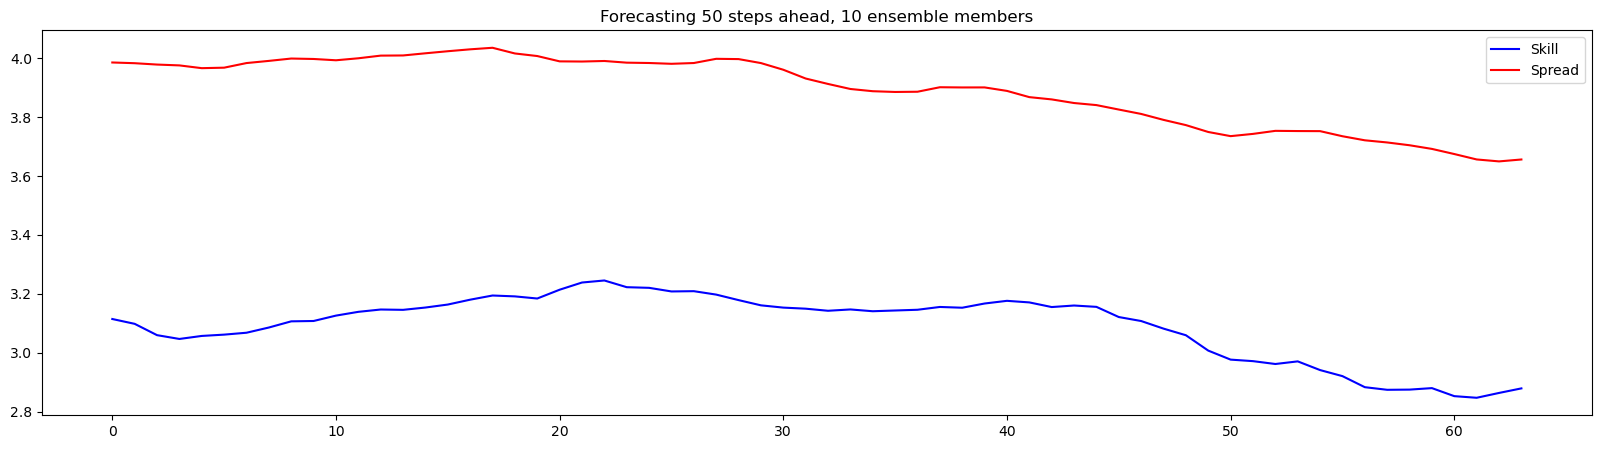

In [29]:
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
running_mean=50
axes.plot(uniform_filter1d(res['skill'], size=running_mean), label='Skill', color='blue')
axes.set_title(f'Forecasting {k} steps ahead, {n_ens} ensemble members')
axes.plot(uniform_filter1d(res['spread'], size=running_mean), label='Spread', color='red')
axes.legend()

In [30]:
plt.figure(figsize=(15,5))
running_mean=50
# Calculate the mean and standard deviation of rmse_model
mean_rmse = np.mean(rmse, axis=0)
std_rmse = np.std(rmse, axis=0)
min_rmse = np.min(rmse, axis=0)
max_rmse = np.max(rmse, axis=0)
plt.title(f'Forecasting {k} steps ahead, {n_ens} ensemble members')

# Plot the mean line
plt.plot(uniform_filter1d(mean_rmse, size=running_mean), label='Mean RMSE', color='blue')

# Plot the standard deviation band
plt.fill_between(range(len(mean_rmse)), uniform_filter1d(mean_rmse - std_rmse, size=running_mean), uniform_filter1d(mean_rmse + std_rmse, size=running_mean), alpha=0.2, color='green', label="1 std")
plt.fill_between(range(len(mean_rmse)), uniform_filter1d(min_rmse, size=running_mean), uniform_filter1d(max_rmse, size=running_mean), alpha=0.2, color='blue', label="min-max")
# Add labels and legend
plt.xlabel('Time')
plt.ylabel('RMSE')

# Show the plot

#plt.plot(rmse_model, label='RMSE Model', linewidth=0.05)
#plt.plot(uniform_filter1d(nwp_skill, size=running_mean), label='RMSE NWP', color='r')
#plt.plot(var_model, label='Var Model', color='g')
plt.plot(uniform_filter1d(skill, size=running_mean), label='Skill', color='m')
plt.plot(spread, label='Spread', color='y')
#plt.plot(crps, label='CRPS Model', color='c')
#plt.plot(brier, label='Brier Model', color='k')
plt.legend()
plt.show()

NameError: name 'rmse' is not defined

<Figure size 1500x500 with 0 Axes>

ValueError: x and y must have same first dimension, but have shapes (512,) and (2560,)

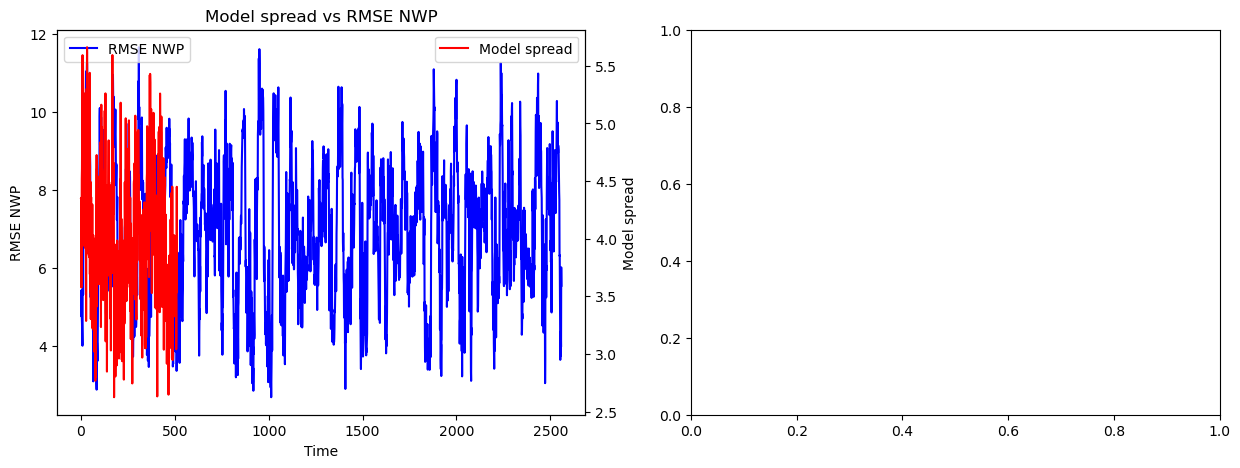

In [23]:

key = 'spread'
running_mean = 1
x = np.arange(0, len(nwp_skill))

fig, axes = plt.subplots(1,2, figsize=(15,5))

ax1 = axes[0]
ax2 = ax1.twinx()
ax1.set_title(f'Model {key} vs RMSE NWP')

ax1.plot(uniform_filter1d(nwp_skill, size=running_mean), color='blue', label='RMSE NWP')
ax1.set_xlabel('Time')
ax1.set_ylabel('RMSE NWP')

ax2.set_ylabel(f'Model {key}')
ax2.plot(uniform_filter1d(res[key], size=running_mean), color='red', label=f'Model {key}')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax3 = axes[1]
ax3.plot(uniform_filter1d(res[key], size=running_mean), uniform_filter1d(nwp_skill, size=running_mean), marker='.', linestyle='')
ax3.set_title(f'Model {key} vs RMSE NWP')
ax3.set_xlabel(f'Model {key}')
ax3.set_ylabel('RMSE NWP')

plt.tight_layout()
plt.show()


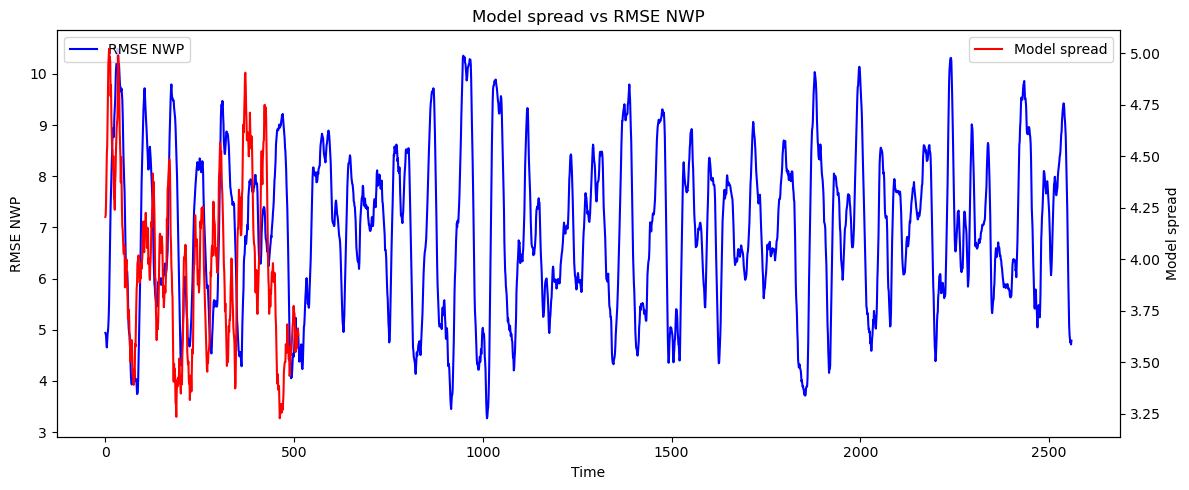

In [24]:
running_mean=10
key = 'spread'

x = np.arange(0, len(nwp_skill))

fig, axes = plt.subplots(1,1, figsize=(12,5))

ax1 = axes
ax2 = ax1.twinx()
ax1.set_title(f'Model {key} vs RMSE NWP')

ax1.plot(uniform_filter1d(nwp_skill, size=running_mean), color='blue', label='RMSE NWP')
ax1.set_xlabel('Time')
ax1.set_ylabel('RMSE NWP')

ax2.set_ylabel(f'Model {key}')
ax2.plot(uniform_filter1d(res[key], size=running_mean), color='red', label=f'Model {key}')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


### Likelihood

#### Generate first then estimate

In [12]:
def generate_complete_solution_from_single_random(model, n_ens=10, selected_loader = shuffled_val_loader, sampler_fn=complete_edm_sampler, num_steps=20):
    model.eval()

    for previous, current in selected_loader:
        previous_unbatched = previous[0].unsqueeze(0)
        current_unbatched = current[0].unsqueeze(0)
        break


    with torch.no_grad():
        previous_latent = autoencoder.encoder(previous_unbatched)

        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        latents = torch.randn_like(class_labels, device=device)

        time_labels = torch.ones(n_ens, device=device, dtype=int) * k / kmax
        
        predicted_residuals, predicted_residuals_list = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=num_steps, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        predicted_latent = previous_latent + predicted_residuals * std_residual_latent
        
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data
        current_unnormalized = current_unbatched * std_data + mean_data
        previous_unnormalized = previous_unbatched * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, 1, previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized, latents, predicted_residuals_list, current_unnormalized, class_labels

torch.manual_seed(0)
num_steps = 20
n_ens = 10
predicted_unnormalized, latents, predicted_residuals_list, current_unnormalized, class_labels = generate_complete_solution_from_single_random(model, n_ens=n_ens, selected_loader = shuffled_val_loader, sampler_fn=complete_edm_sampler, num_steps=num_steps)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
def likelihood_estimation(model, samples, latents, sample_list, class_labels, eps_multiplier=1, num_steps=20):
    res_list = {}

    ensemble_rmses = calculate_RMSE(samples, current_unnormalized).flatten()

    res = {}
    for j in tqdm(range(n_ens)):
        
        latent = latents[j].unsqueeze(0)
        sample = sample_list[:,j].unsqueeze(1)
        class_label = class_labels[j].unsqueeze(0)

        likelihood = likelihood_estimator(model, 
                                latent,
                                sample, 
                                class_label,
                                eps_multiplier=eps_multiplier,
                                num_steps=num_steps,
                                sigma_max=80, sigma_min=0.03, rho=7, 
                                S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05).item()
        
        print(likelihood, ensemble_rmses[j])
        
        res[np.round(ensemble_rmses[j],3)] = likelihood
            
    sorted_keys = sorted(res.keys())
    sorted_data = [res[key] for key in sorted_keys]

    #plt.boxplot(sorted_data, labels=sorted_keys)
    plt.plot(sorted_keys, sorted_data, marker='o', linewidth=0)

    plt.show()

    return res

res = likelihood_estimation(model, predicted_unnormalized, latents, predicted_residuals_list, class_labels, eps_multiplier=10, num_steps=num_steps)

#### Estimate And Generate

OBS: We can not do the same boxplots as before since we sample at the same time as calculating likelihood
And also not evaluate the effect of eps_multiplier

In [28]:
def generate_and_estimate_likelihood(model, n_ens=10, selected_loader = shuffled_val_loader, sampler_fn=likelihood_sampler, num_steps=20, eps_multiplier=1):

    model.eval()

    for previous, current in selected_loader:
        previous_unbatched = previous[0].unsqueeze(0).to(device)
        current_unbatched = current[0].unsqueeze(0).to(device)
        break

    with torch.no_grad():
        previous_latent = autoencoder.encoder(previous_unbatched)

        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        latents = torch.randn_like(class_labels, device=device)
        time_labels = torch.ones(class_labels.shape[0], device=device) * k / kmax

        current_unnormalized = current_unbatched * std_data + mean_data
        previous_unnormalized = previous_unbatched * std_data + mean_data

    predicted_unnormalized_ensemble = torch.zeros((n_ens, 1, previous.size(1), previous.size(2), previous.size(3)), device=device)
    likelihood_ensemble = np.zeros(n_ens)
    rmse_ensemble = np.zeros(n_ens)
    mae_ensemble = np.zeros(n_ens)

    for j in tqdm(range(n_ens)):
        with torch.no_grad():
            latent = latents[j].unsqueeze(0)
            class_label = class_labels[j].unsqueeze(0)
            time_labels = torch.ones(1, device=device, dtype=int) * k

            predicted_residuals, likelihood  = sampler_fn(model, 
                                    latent, 
                                    class_label,
                                    time_labels / kmax,
                                    eps_multiplier=eps_multiplier,
                                    num_steps=num_steps,
                                    sigma_max=80, sigma_min=0.03, rho=7, 
                                    S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
            
            predicted_latent = previous_latent + predicted_residuals * residual_scaling(time_labels)
            
            predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

            predicted_unnormalized = predicted * std_data + mean_data
            predicted_unnormalized_ensemble[j] = predicted_unnormalized
            likelihood_ensemble[j] = likelihood.item()

            # ----
            ensemble_rmse = calculate_RMSE(predicted_unnormalized, current_unnormalized).flatten()
            ensemble_mae = calculate_MAE(predicted_unnormalized, current_unnormalized).flatten()
            
            rmse_ensemble[j] = ensemble_rmse.item()
            mae_ensemble[j] = ensemble_mae.item()
            print(f"Likelihood {j}: {likelihood.item():.0f}, RMSE {j}: {rmse_ensemble[j]:.2f}, MAE {j}: {mae_ensemble[j]:.2f}")
        
    return predicted_unnormalized_ensemble, current_unnormalized, likelihood_ensemble, rmse_ensemble, mae_ensemble

In [ ]:
n_ens = 1
eps_multiplier = 1
num_steps = 50

predicted_unnormalized_ensemble, current_unnormalized, likelihood_ensemble, rmse_ensemble, mae_ensemble = generate_and_estimate_likelihood(model, n_ens=n_ens, selected_loader = shuffled_val_loader, sampler_fn=likelihood_sampler, num_steps=num_steps, eps_multiplier=eps_multiplier)

plt.figure(figsize=(6,6))
plt.xlabel('MAE')
plt.ylabel('Likelihood')
plt.title('Likelihood vs RMSE')
plt.plot(rmse_ensemble, -likelihood_ensemble, marker='o', linestyle='')

Some more tests

In [65]:
model.eval()

for previous, current in shuffled_val_loader:
    previous_unbatched = previous[0].unsqueeze(0).to(device)
    current_unbatched = current[0].unsqueeze(0).to(device)
    break

with torch.no_grad():
    previous_latent = autoencoder.encoder(previous_unbatched)

    class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
    latent = torch.randn_like(previous_latent, device=device)#.repeat(n_ens, 1, 1, 1)
    time_labels = torch.ones(class_labels.shape[0], device=device) * k / kmax

    current_unnormalized = current_unbatched * std_data + mean_data
    previous_unnormalized = previous_unbatched * std_data + mean_data


In [91]:
n_ens = 10
eps_multiplier = 1
num_steps = 100

latents = latent.repeat(n_ens, 1, 1, 1)
class_labels = previous_latent.repeat(n_ens, 1, 1, 1)


predicted_unnormalized_ensemble = torch.zeros((n_ens, 1, previous.size(1), previous.size(2), previous.size(3)), device=device)
likelihood_ensemble = np.zeros(n_ens)
rmse_ensemble = np.zeros(n_ens)
mae_ensemble = np.zeros(n_ens)

for j in (range(n_ens)):
    with torch.no_grad():
        latent = latents[j].unsqueeze(0)
        class_label = class_labels[j].unsqueeze(0)
        time_labels = torch.ones(1, device=device, dtype=int) * k

        predicted_residuals, likelihood  = likelihood_sampler(model, 
                                latent, 
                                class_label,
                                time_labels / kmax,
                                eps_multiplier=eps_multiplier,
                                num_steps=num_steps,
                                sigma_max=80, sigma_min=0.03, rho=7, 
                                S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        
        predicted_latent = previous_latent + predicted_residuals * residual_scaling(time_labels)
        
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data
        predicted_unnormalized_ensemble[j] = predicted_unnormalized
        likelihood_ensemble[j] = likelihood.item()

        # ----
        ensemble_rmse = calculate_RMSE(predicted_unnormalized, current_unnormalized).flatten()
        ensemble_mae = calculate_MAE(predicted_unnormalized, current_unnormalized).flatten()
        
        rmse_ensemble[j] = ensemble_rmse.item()
        mae_ensemble[j] = ensemble_mae.item()
        print(f"Likelihood {j}: {likelihood.item():.0f}, RMSE {j}: {rmse_ensemble[j]:.3f}, MAE {j}: {mae_ensemble[j]:.3f}")
        #print(f"{likelihood.item():.0f}")

plt.hist(likelihood_ensemble)

Likelihood 0: 2131, RMSE 0: 3.602, MAE 0: 1.886


KeyboardInterrupt: 

(array([ 3.,  3.,  7., 29., 19., 18.,  9.,  8.,  2.,  2.]),
 array([2053.77612305, 2129.97150879, 2206.16689453, 2282.36228027,
        2358.55766602, 2434.75305176, 2510.9484375 , 2587.14382324,
        2663.33920898, 2739.53459473, 2815.72998047]),
 <BarContainer object of 10 artists>)

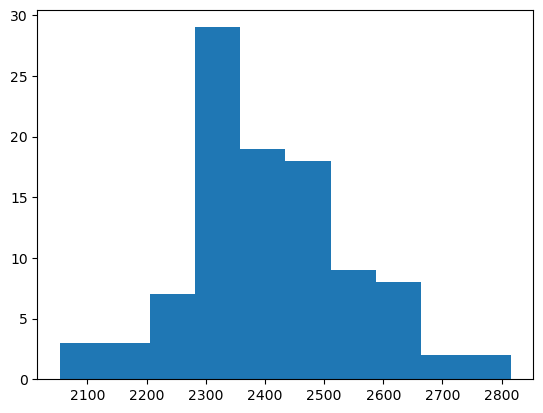

In [77]:
N:20
eps:1
n_ens:100
plt.hist(likelihood_ensemble)

(array([3., 2., 1., 1., 1., 0., 0., 0., 1., 1.]),
 array([2329.66577148, 2346.62043457, 2363.57509766, 2380.52976074,
        2397.48442383, 2414.43908691, 2431.39375   , 2448.34841309,
        2465.30307617, 2482.25773926, 2499.21240234]),
 <BarContainer object of 10 artists>)

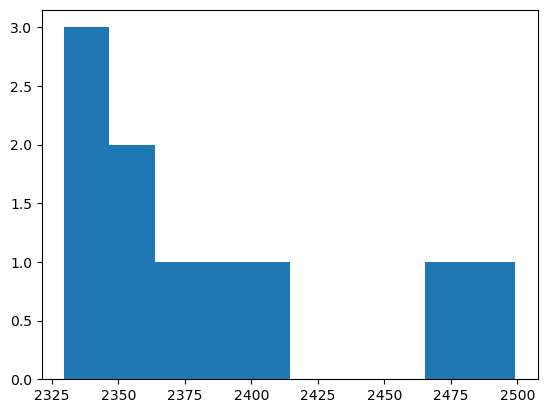

In [80]:
N:20
eps:10
n_ens:10
plt.hist(likelihood_ensemble)

(array([1., 0., 0., 0., 1., 2., 0., 0., 3., 3.]),
 array([1966.28747559, 1996.02269287, 2025.75791016, 2055.49312744,
        2085.22834473, 2114.96356201, 2144.6987793 , 2174.43399658,
        2204.16921387, 2233.90443115, 2263.63964844]),
 <BarContainer object of 10 artists>)

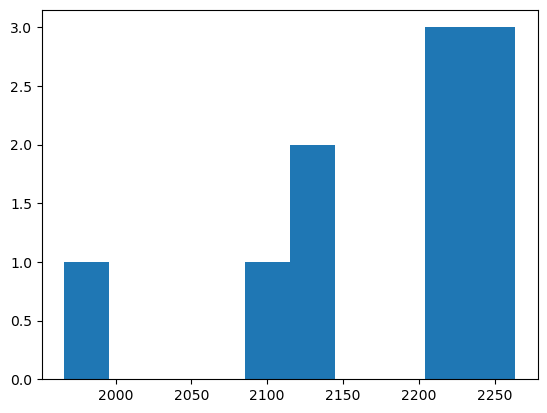

In [87]:
N:100
eps:1
n_ens:10
plt.hist(likelihood_ensemble)

(array([1., 0., 1., 1., 1., 0., 3., 1., 0., 2.]),
 array([2325.72436523, 2336.60900879, 2347.49365234, 2358.3782959 ,
        2369.26293945, 2380.14758301, 2391.03222656, 2401.91687012,
        2412.80151367, 2423.68615723, 2434.57080078]),
 <BarContainer object of 10 artists>)

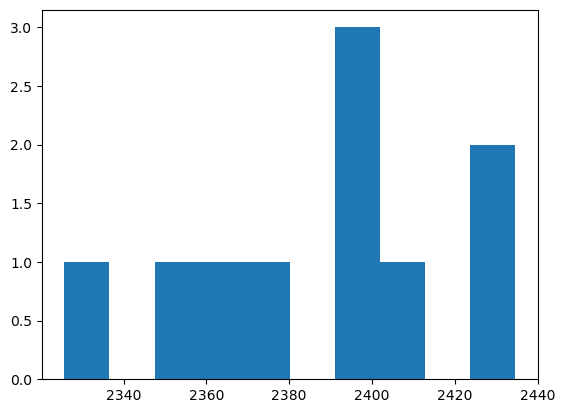

In [82]:
N:20
eps:20
n_ens:10
plt.hist(likelihood_ensemble)

(array([2., 0., 1., 0., 1., 2., 1., 0., 2., 1.]),
 array([2352.02050781, 2360.79736328, 2369.57421875, 2378.35107422,
        2387.12792969, 2395.90478516, 2404.68164062, 2413.45849609,
        2422.23535156, 2431.01220703, 2439.7890625 ]),
 <BarContainer object of 10 artists>)

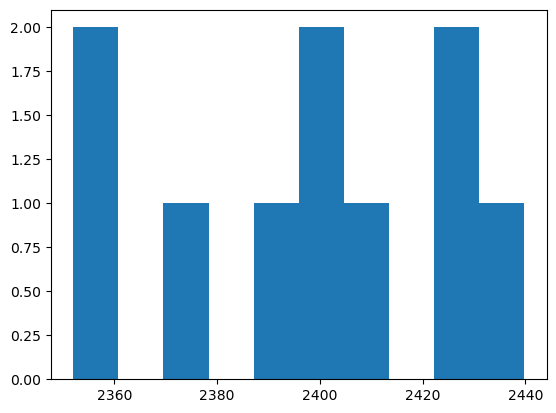

In [84]:
N:20
eps:50
n_ens:10
plt.hist(likelihood_ensemble)

(array([1., 0., 1., 2., 2., 1., 1., 0., 0., 2.]),
 array([2111.36987305, 2119.76921387, 2128.16855469, 2136.56789551,
        2144.96723633, 2153.36657715, 2161.76591797, 2170.16525879,
        2178.56459961, 2186.96394043, 2195.36328125]),
 <BarContainer object of 10 artists>)

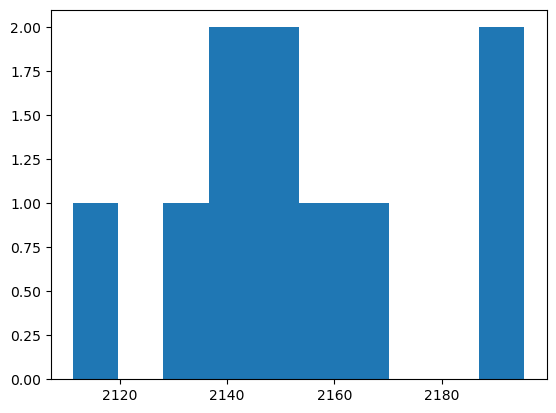

In [90]:
N:1000
eps:1
n_ens:10
plt.hist(likelihood_ensemble)

(array([1., 1., 5., 1., 0., 1., 0., 0., 0., 1.]),
 array([2071.73852539, 2097.12053223, 2122.50253906, 2147.8845459 ,
        2173.26655273, 2198.64855957, 2224.03056641, 2249.41257324,
        2274.79458008, 2300.17658691, 2325.55859375]),
 <BarContainer object of 10 artists>)

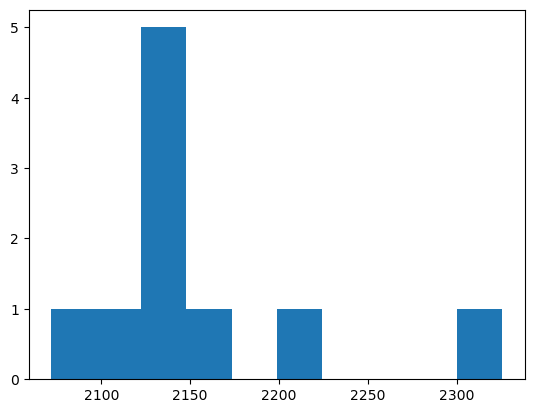

In [71]:
100: 
2326
2145
2133
2139
2208
2164
2072
2138
2141
2121

In [ ]:
10: RMSE 0: 5.263, MAE 0: 2.601
15: RMSE 0: 5.061, MAE 0: 2.474
20: RMSE 0: 5.021, MAE 0: 2.449
30: RMSE 0: 4.972, MAE 0: 2.422
40: RMSE 0: 4.975, MAE 0: 2.419
50: RMSE 0: 4.949, MAE 0: 2.409
60: RMSE 0: 4.939, MAE 0: 2.404
70: RMSE 0: 4.945, MAE 0: 2.407
100: RMSE 0: 4.946, MAE 0: 2.406

In [ ]:
rmse_to_mean = calculate_RMSE(predicted_unnormalized_ensemble, predicted_unnormalized_ensemble.mean(dim=0)).flatten()
mae_to_mean = calculate_MAE(predicted_unnormalized_ensemble, predicted_unnormalized_ensemble.mean(dim=0)).flatten()

In [ ]:
plt.plot(rmse_to_mean, rmse_ensemble, marker='o', linestyle='')

In [ ]:
import numpy as np

correlation = np.corrcoef(mae_to_mean, rmse_ensemble)[0, 1]
correlation


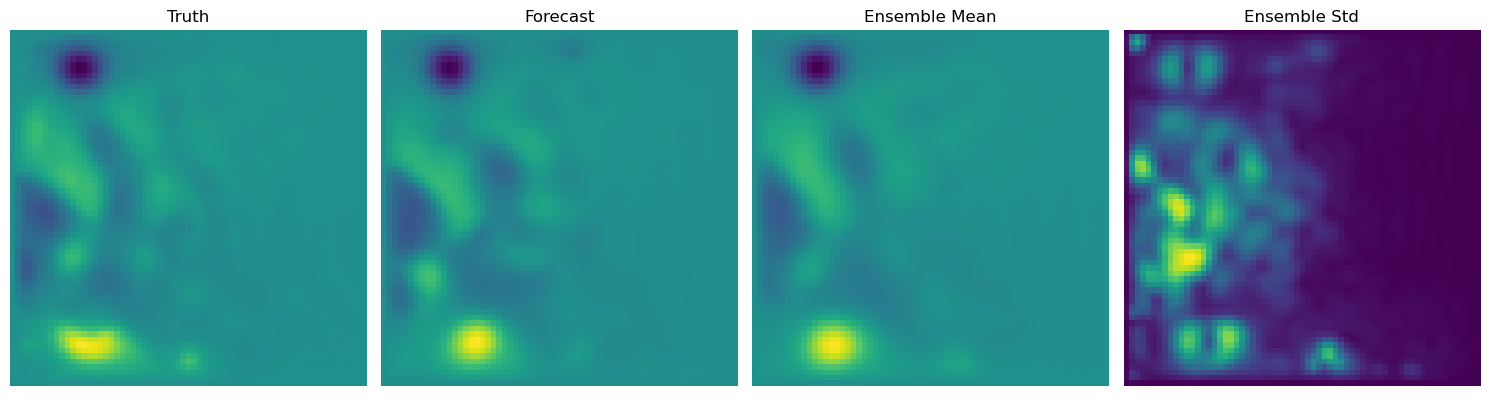

In [43]:
rand_idx = np.random.randint(0, n_ens)
fig, axes = plt.subplots(1, 4, figsize=(15, 10))

axes[0].imshow(current_unnormalized[0,0].cpu().detach().numpy())
axes[0].set_title('Truth')
axes[0].axis('off')
axes[1].imshow(predicted_unnormalized_ensemble[rand_idx,0,0].cpu().detach().numpy())
axes[1].set_title('Forecast')
axes[1].axis('off')
axes[2].imshow(predicted_unnormalized_ensemble.mean(dim=0)[0,0].cpu().detach().numpy())
axes[2].set_title('Ensemble Mean')
axes[2].axis('off')
axes[3].imshow(predicted_unnormalized_ensemble.std(dim=0)[0,0].cpu().detach().numpy())
axes[3].set_title('Ensemble Std')
axes[3].axis('off')




plt.tight_layout()


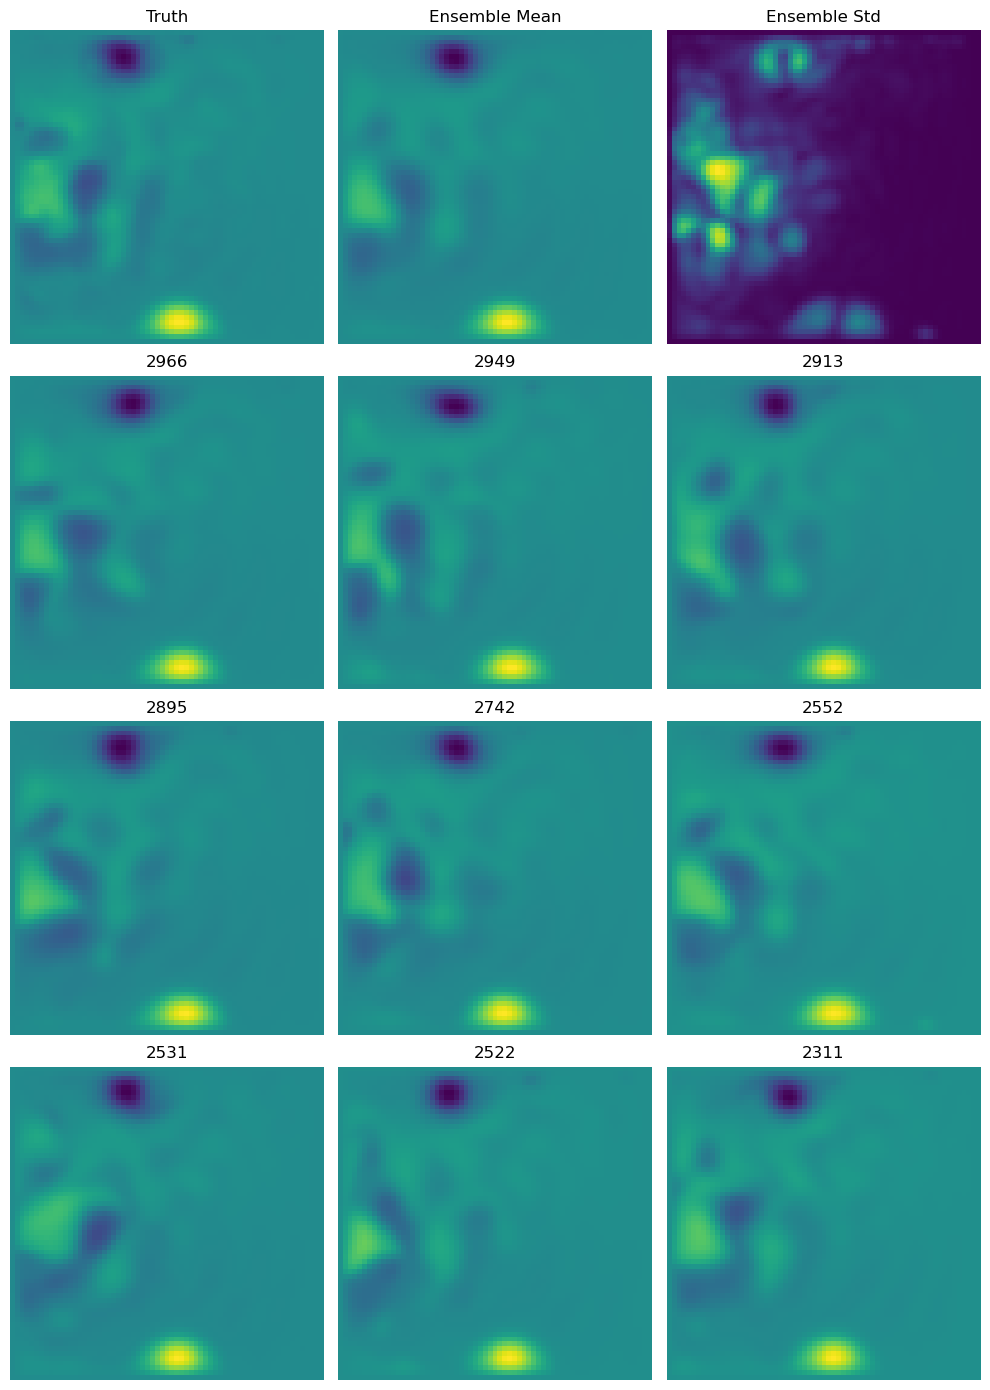

In [15]:
# Sort the forecasts based on likelihood
sorted_indices = np.argsort(-likelihood_ensemble)
sorted_forecasts = predicted_unnormalized_ensemble[sorted_indices]

# Plot the sorted forecasts
fig, axes = plt.subplots(4, 3, figsize=(10,14))

for i, ax in enumerate(axes):
    for j, ax in enumerate(ax):
        l = i*3+j
        if l == 0:
            ax.imshow(current_unnormalized[0,0].cpu().detach().numpy())
            ax.set_title('Truth')
        elif l == 1:
            ax.imshow(predicted_unnormalized_ensemble.mean(dim=0)[0,0].cpu().detach().numpy())
            ax.set_title('Ensemble Mean')
        elif l == 2:
            ax.imshow(predicted_unnormalized_ensemble.std(dim=0)[0,0].cpu().detach().numpy())
            ax.set_title('Ensemble Std')
        else:
            ax.imshow(sorted_forecasts[l-3, 0, 0].cpu().detach().numpy())
            ax.set_title(f'{likelihood_ensemble[sorted_indices[l-3,]]:.0f}')
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
plt.plot(mae_ensemble, rmse_ensemble, marker='o', linestyle='')

#### Sampling + Likelihood as in original paper

Slower than current method.

In [ ]:
from likelihood import get_likelihood_fn

for previous, current in val_loader:
    prev = autoencoder.encoder(previous)[0:10]#.unsqueeze(0)
    curr = autoencoder.encoder(current)[0:10]#.unsqueeze(0)
    break

likelihood_fn = get_likelihood_fn(model, atol=10, rtol=0.1)
res = likelihood_fn(model, curr, prev)
A = res[-1,:]

In [ ]:
def generate_forecast_likelihood(model, previous, n_ens=10, sampler_fn=edm_sampler):
    model.eval()
    
    previous = previous.unsqueeze(0)
    previous_latent = autoencoder.encoder(previous)
    
    latents = torch.randn([n_ens, model.img_channels//2, model.img_resolution, model.img_resolution], device=device)
    class_labels = previous_latent.repeat(n_ens, 1, 1, 1)

    predicted_residuals, _  = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
    predicted_latent = class_labels + predicted_residuals * std_residual_latent
    predicted = autoencoder.decoder(predicted_latent.to(torch.float32))
    predicted_unscaled = predicted * std_data + mean_data

    also_sample, logp = likelihood_fn(model, latents, previous_latent)
    also_sample = class_labels + also_sample * std_residual_latent
    also_sample = autoencoder.decoder(also_sample.to(torch.float32))
    also_sample = also_sample * std_data + mean_data

    return predicted_unscaled, also_sample, logp

In [ ]:
res = generate_forecast_likelihood(model, previous[0], n_ens=1)
pred, also_pred, logp = res
print(logp)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(pred.detach().cpu().numpy()[0,0])
axes[0].axis('off')
axes[0].set_title('Pred')

axes[1].imshow(also_pred.detach().cpu().numpy()[0,0])
axes[1].axis('off')
axes[1].set_title(f'Also {((also_pred - current[0])**2).mean(dim=(2,3)).sqrt().cpu().detach().numpy().flatten()}')


axes[2].imshow(current.detach().cpu().numpy()[0,0])
axes[2].axis('off')
axes[2].set_title('Current')
